# Data Extraction via ColiVara

In addition to RAG. ColiVara processes and preps documents for data extractions. So - structured data can be extracted from it easily.

Briefly, it converts 100+ document types (docX, powerpoint, pdf, etc.) into pdf, breaks down into logical page chunks, convert each page to base64 image, and create embeddings to allow for semantic search.

In this example - a user will provide us a document and what structured data they want to extract to illustrate the capabilities. However, you can combine RAG and data extraction together for full agentic AI pipelines.

For example - we can upload an organization's legal and administrative policies, and automatically notify folks when they become too old and need to be reviewed - with AI-assisted reviews.

## Step 1: client setup

We want to download and install colivara_py. As well as initial the ColiVara client with an API Key. To get an API key, sign up for free at colivara.com

In [ ]:
!pip install --no-cache-dir --upgrade colivara_py
from colivara_py import ColiVara
# the client looks for COLIVARA_API_KEY in the environment if not provided
client = ColiVara(api_key="your-api-key")


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


## Step 2: get your documents ready

Next - we want to download some example files. You can download and use files from our demo repo (below) or you can skip this step and use your own.

In [ ]:
import requests
import os

def download_file(url, local_filename):
    # Send a GET request to the URL
    response = requests.get(url)
    
    # Check if the request was successful
    if response.status_code == 200:
        # Ensure the 'docs' directory exists
        os.makedirs('docs', exist_ok=True)
        
        # Write the content to a local file
        with open(local_filename, 'wb') as f:
            f.write(response.content)
        print(f"Successfully downloaded: {local_filename}")
    else:
        print(f"Failed to download: {url}")

# URLs and local filenames
files = [
    {
        "url": "https://github.com/tjmlabs/colivara-demo/raw/main/docs/Work-From-Home%20Guidance.pdf",
        "filename": "docs/Work-From-Home-Guidance.pdf"
    },
    {
        "url": "https://github.com/tjmlabs/colivara-demo/raw/main/docs/StaffVendorPolicy-Jan2019.pdf",
        "filename": "docs/StaffVendorPolicy-Jan2019.pdf"
    }
]

# Download each file
for file in files:
    download_file(file["url"], file["filename"])

## Step 3: Sync (upload) your documents to the ColiVara server

We want to sync our documents to the ColiVara server. So, we can just call this as our documents change or updated. ColiVara logic automatically updates or inserts new documents depending on what changed.

In [6]:
from colivara_py import ColiVara
from pathlib import Path
import base64

client = ColiVara(api_key="your-api-key")

def sync_documents():    
    # get all the documents under docs/ folder and upsert them to colivara
    documents_dir =  Path('docs')
    files = [f for f in documents_dir.glob('**/*') if f.is_file()]

    for file in files:
        with open(file, 'rb') as f:
            file_content = f.read()
            encoded_content = base64.b64encode(file_content).decode('utf-8')
            client.upsert_document(name=file.name, document_base64=encoded_content, collection_name="demo collection", wait=True)
            print(f"Upserted: {file.name}")

sync_documents()

HTTPError: 401 Client Error: Unauthorized for url: https://api.colivara.com/v1/documents/upsert-document/

Let's peek at what ColiVara processed document looks like.

document_name='Work-From-Home-Guidance.pdf' img_base64='iVBORw0KGgoAAAANSUhEUgAABqQAAAiYCAIAAAA+NVHkAAEAAElEQVR4nOzddWAUx//4/4kHggQIAYITnOJWSgsUd6dAkeKhOKVFixW3IikSrEhxSdDgUggECK4JLhFICIQkEL/fH/N77/c+Z7kYsn0+/rrbnZ2dvdvdZF83My8LjUYjAAAAAAAAAHz5LD91AwAAAAAAAACkD4J9AAAAAAAAgEoQ7AMAAAAAAABUgmAfAAAAAAAAoBIE+wAAAAAAAACVINgHAAAAAAAAqATBPgAAAAAAAEAlCPYBAAAAAAAAKkGwDwAAAAAAAFAJgn0AAAAAAACAShDsAwAAAAAAAFSCYB8AAAAAAACgEgT7AAAAAAAAAJUg2AcAAAAAAACoBME+AAAAAAAAQCUI9gEAAAAAAAAqQbAPAAAAAAAAUAmCfQAAAAAAAIBKEOwDAAAAAAAAVIJgHwAAAAAAAKASBPsAAAAAAAAAlSDYBwAAAAAAAKgEwT4AAAAAAABAJQj2AQAAAAAAACpBsA8AAAAAAABQCYJ9AAAAAAAAgEoQ7AMAAAAAAABUgmAfAAAAAAAAoBIE+wAAAAAAAACVINgHAAAAAAAAqATBPgAAAAAAAEAlCPYBAAAAAAAAKkGwDwAAAAAAAFAJgn0AAAAAAACAShDsAwAAAAAAAFSCYB8AAAAAAACgEgT7AAAAAAAAAJUg2AcAAAAAAACoBME+AAAAAAAAQCUI9gEAAAAAAAAqQbAPAAAAAAAAUAmCfQAAAAAAAIBKEOwDAAAAAAAAVIJgHwAAAAAAAKASBPsAAAAAAAAAlSDYBwAAAAAAAKgEwT4AAAAAAABAJQj2AQAAAAAAACpBsA8AAAAAAABQCYJ9AAAAAAAAgEoQ7AMAAAAAAABUgmAfAAAAAAAAoBIE+wAAAAAAAACVINgHAAAAAAAAqATBPgAA

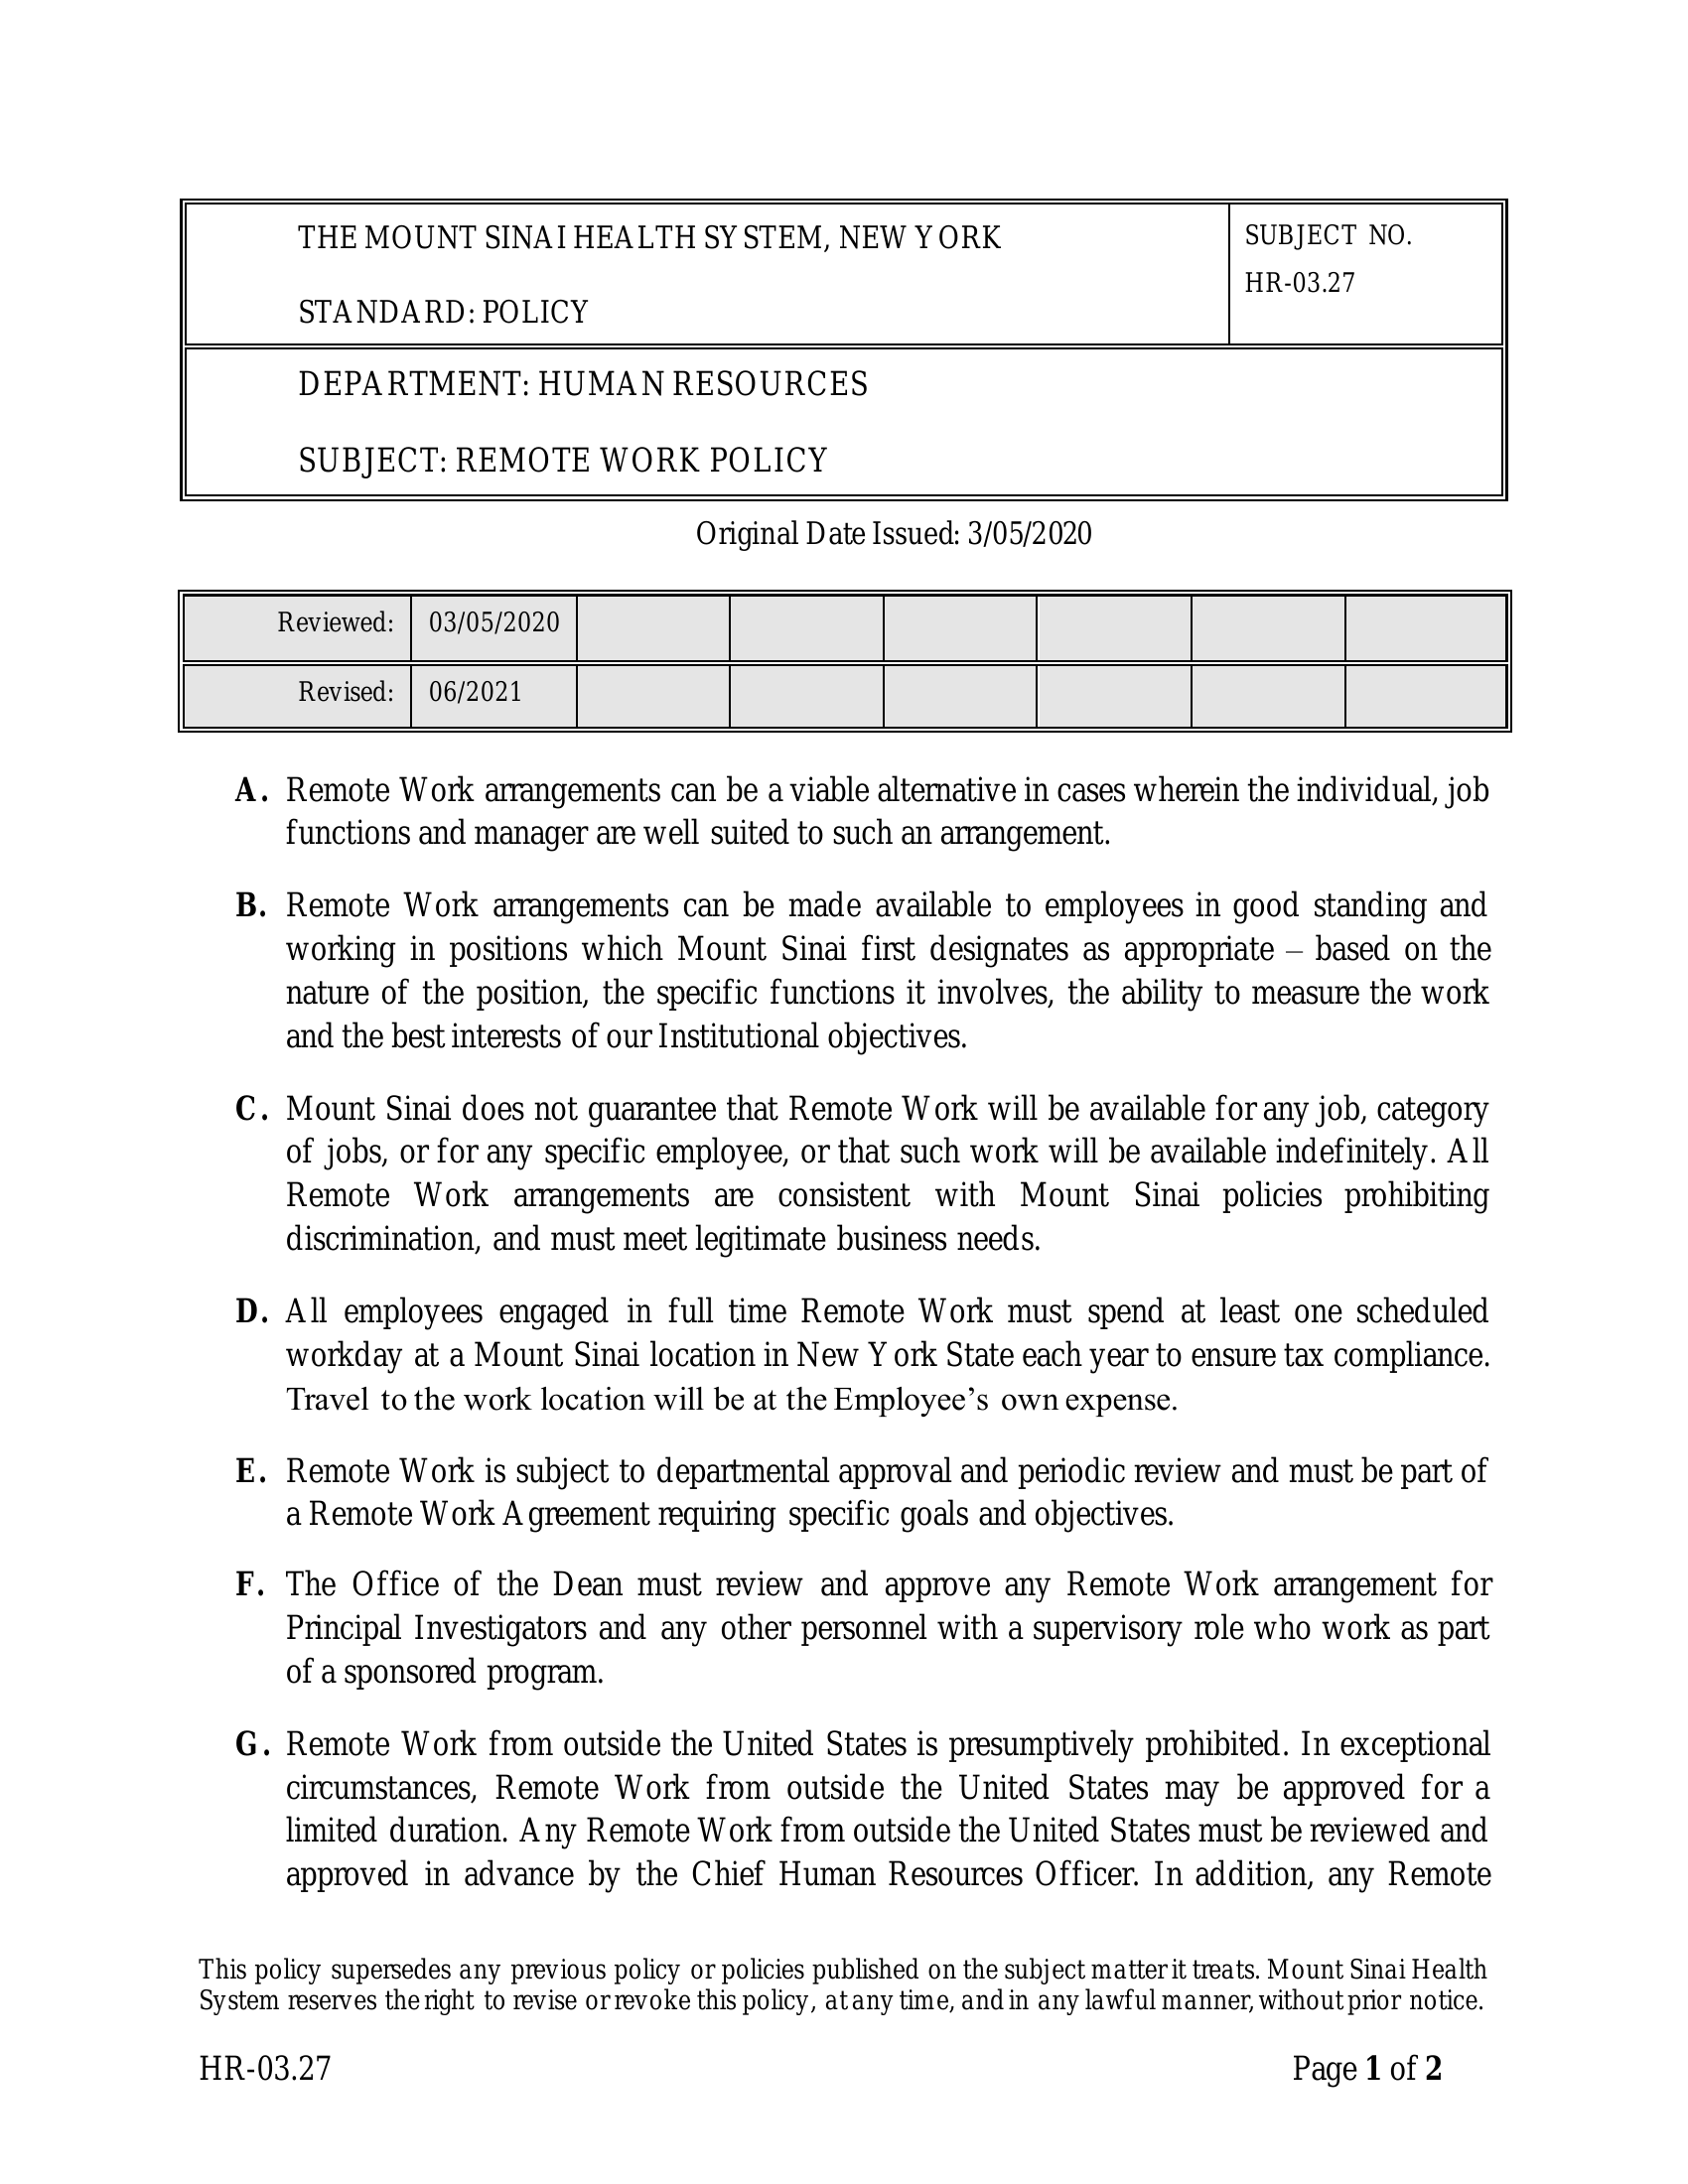

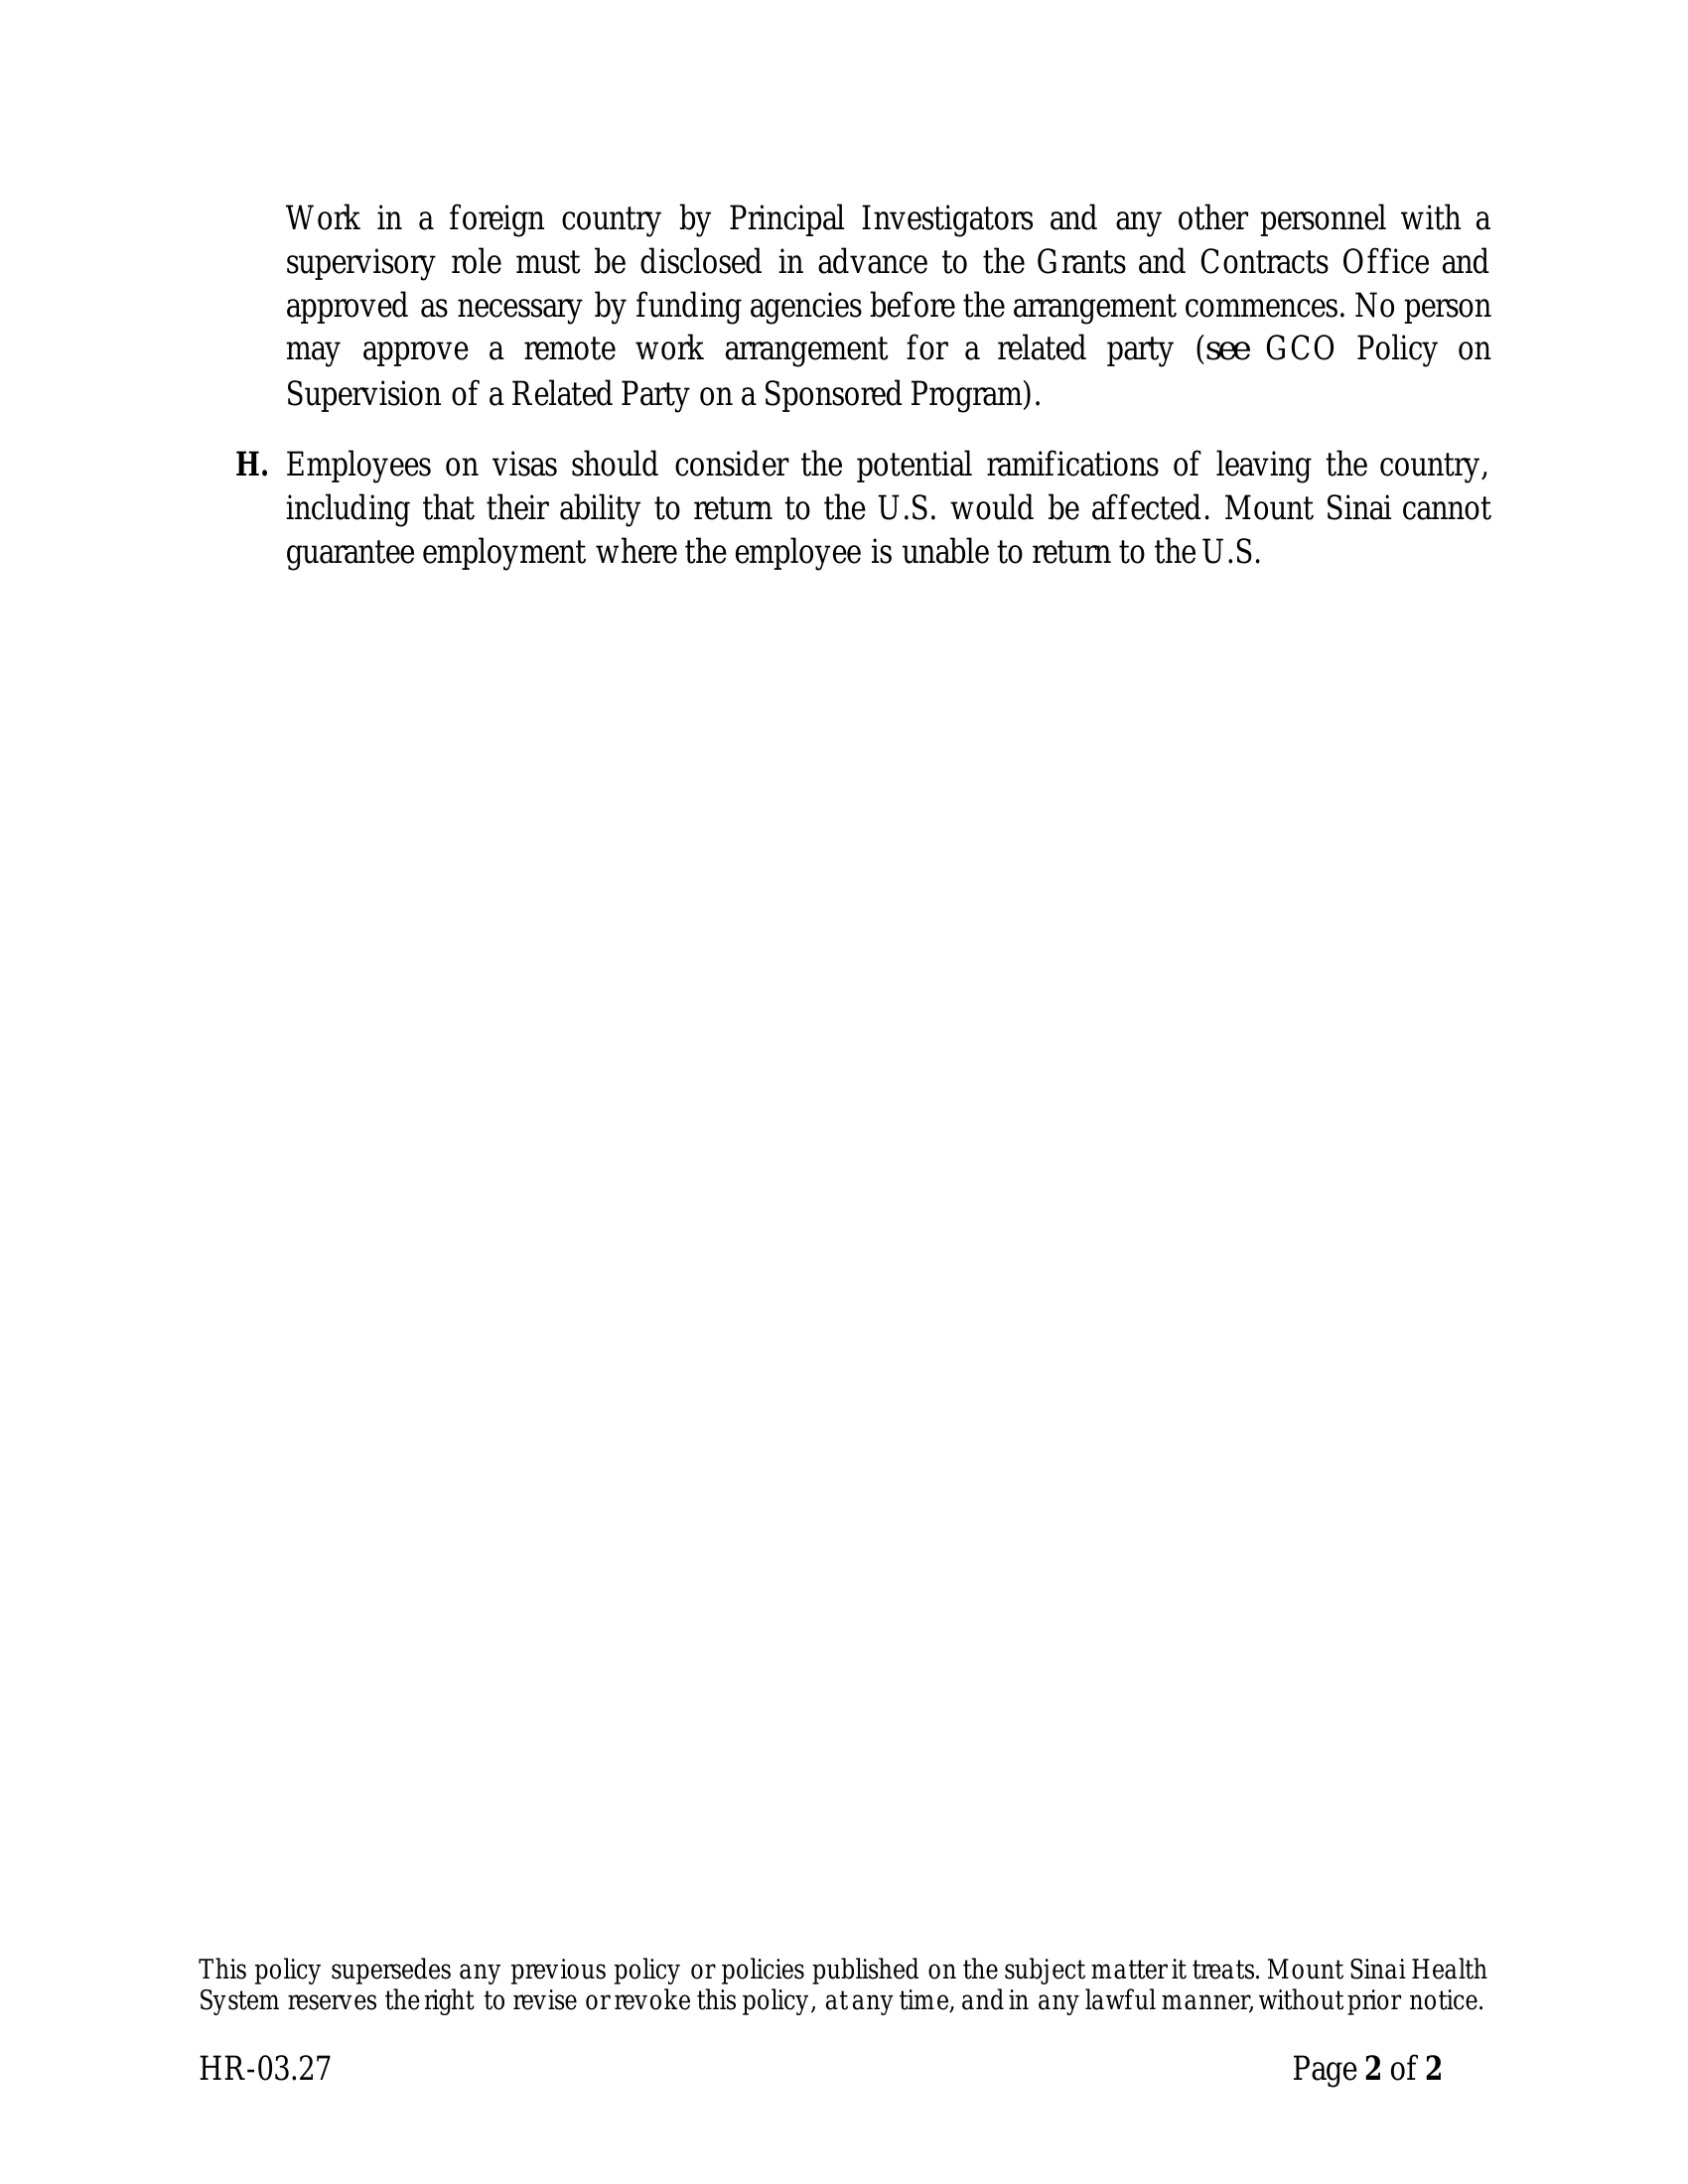

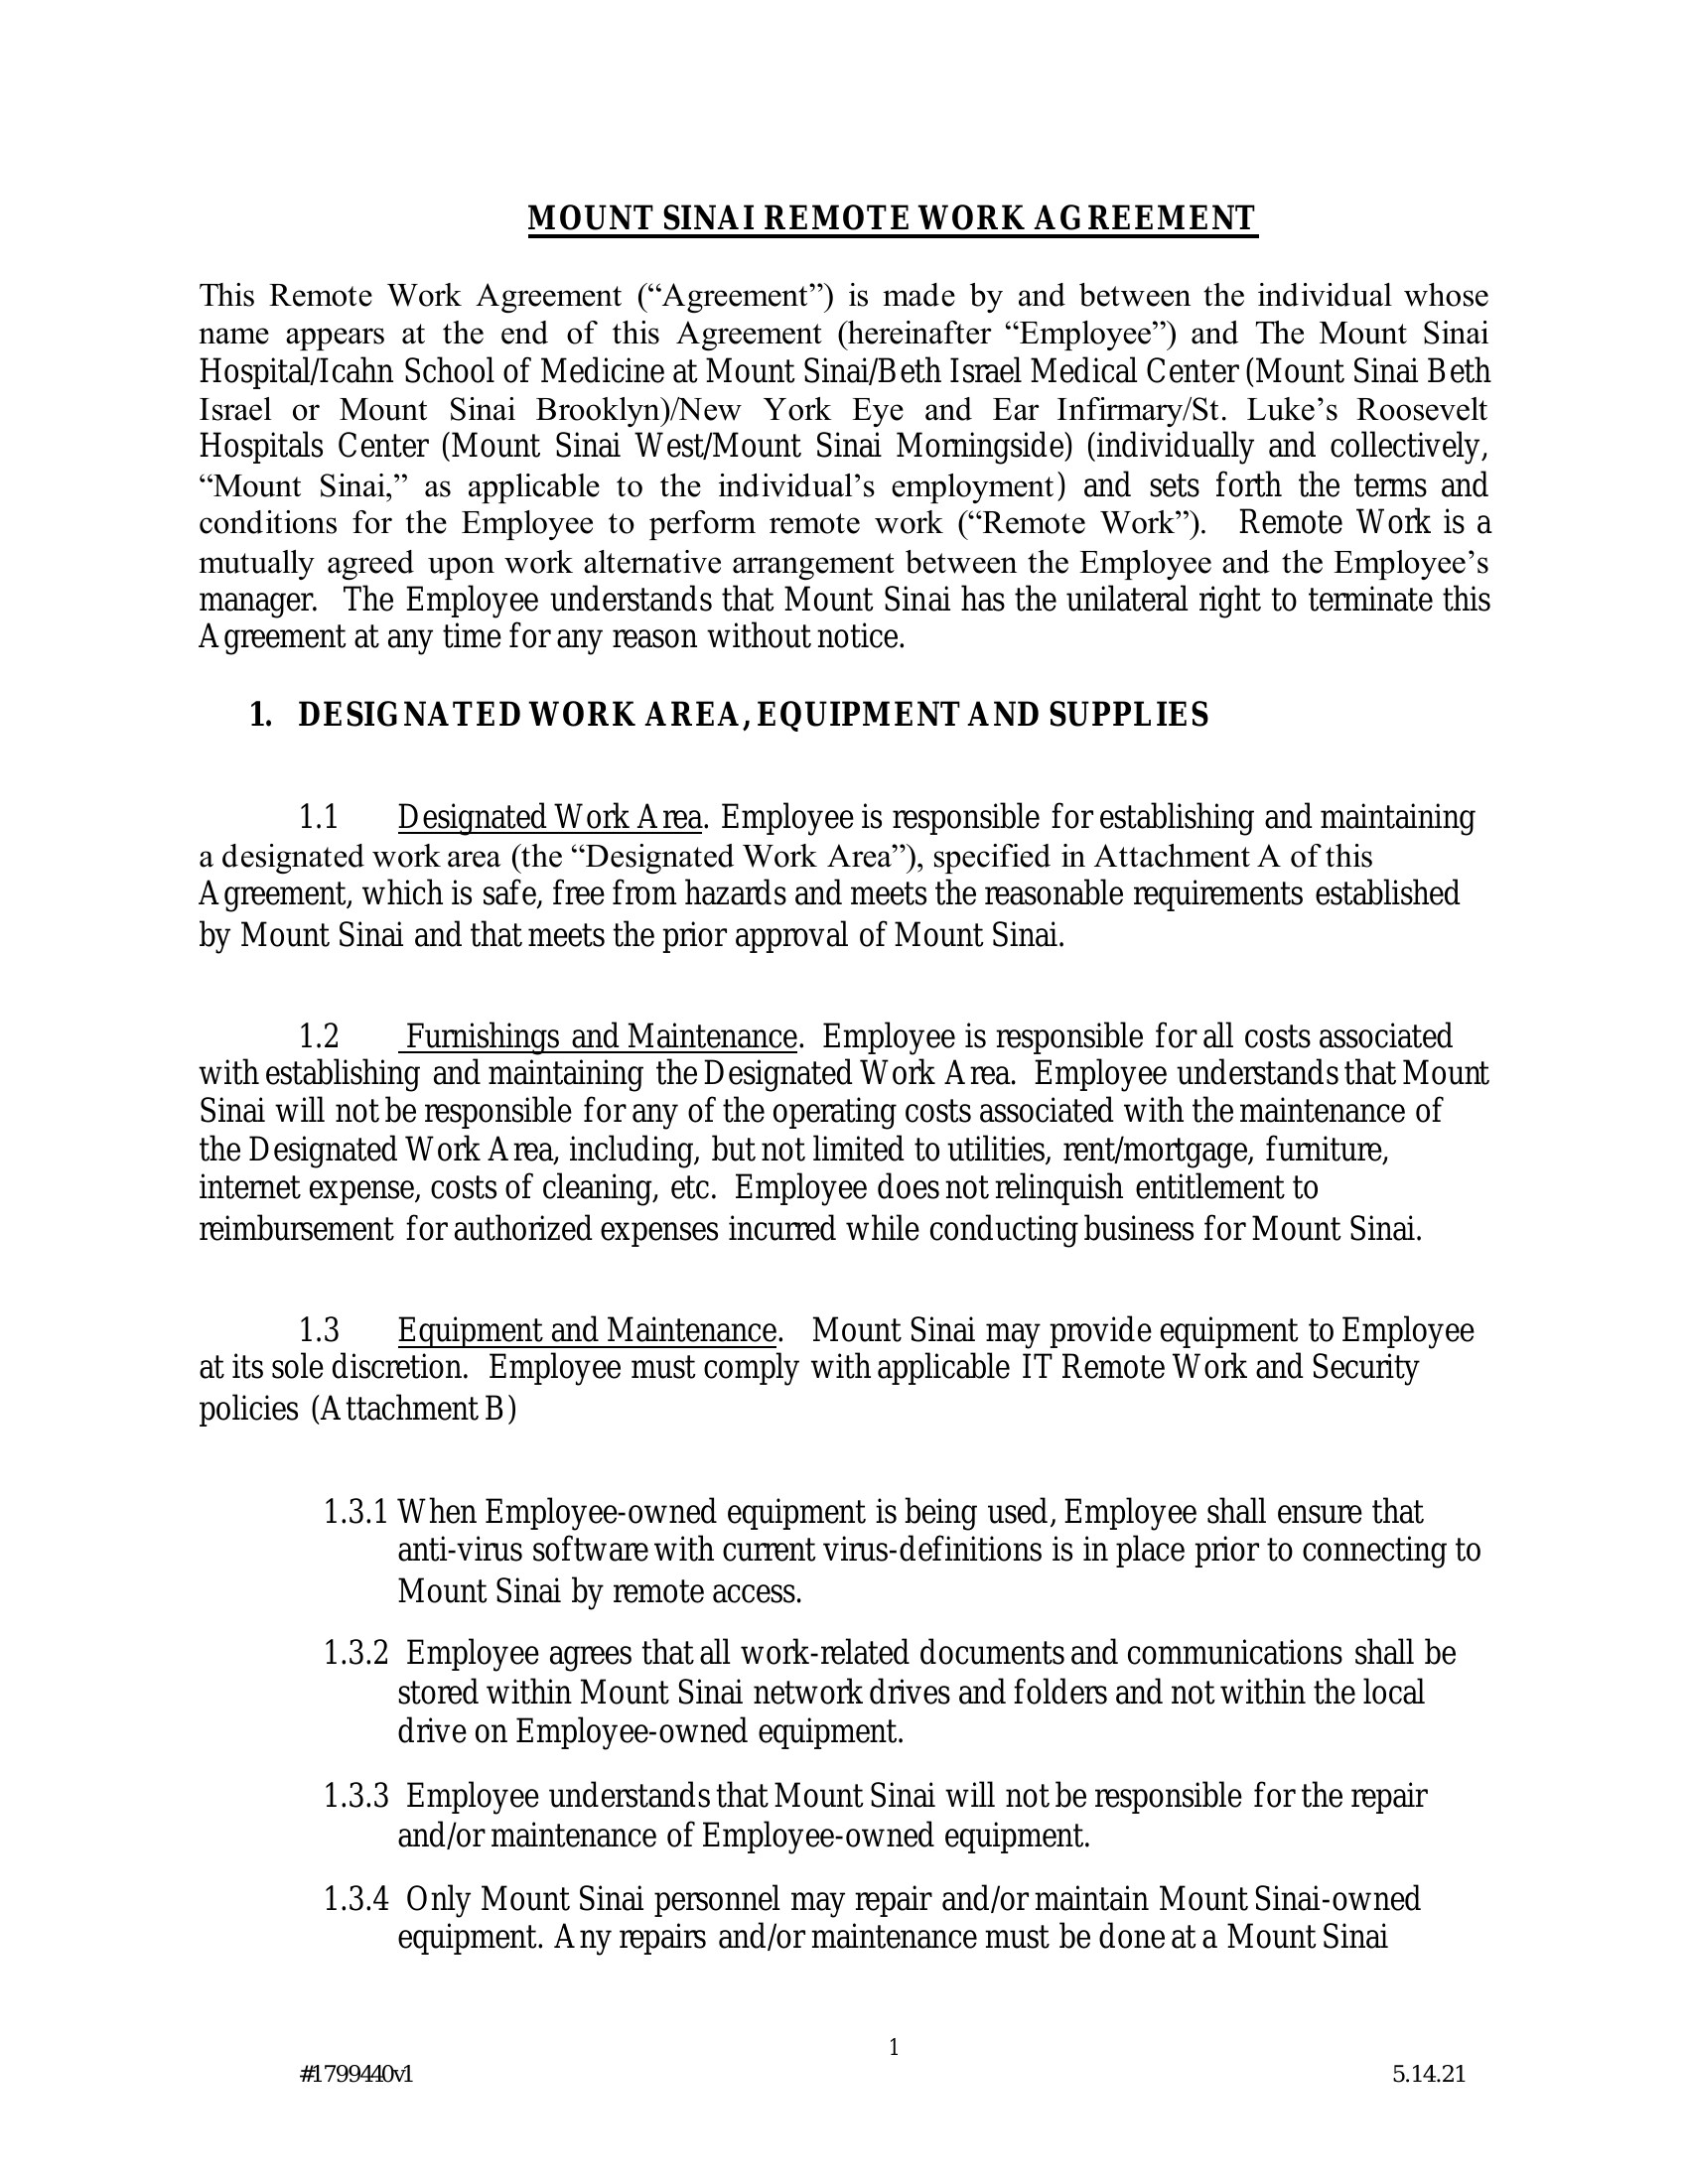

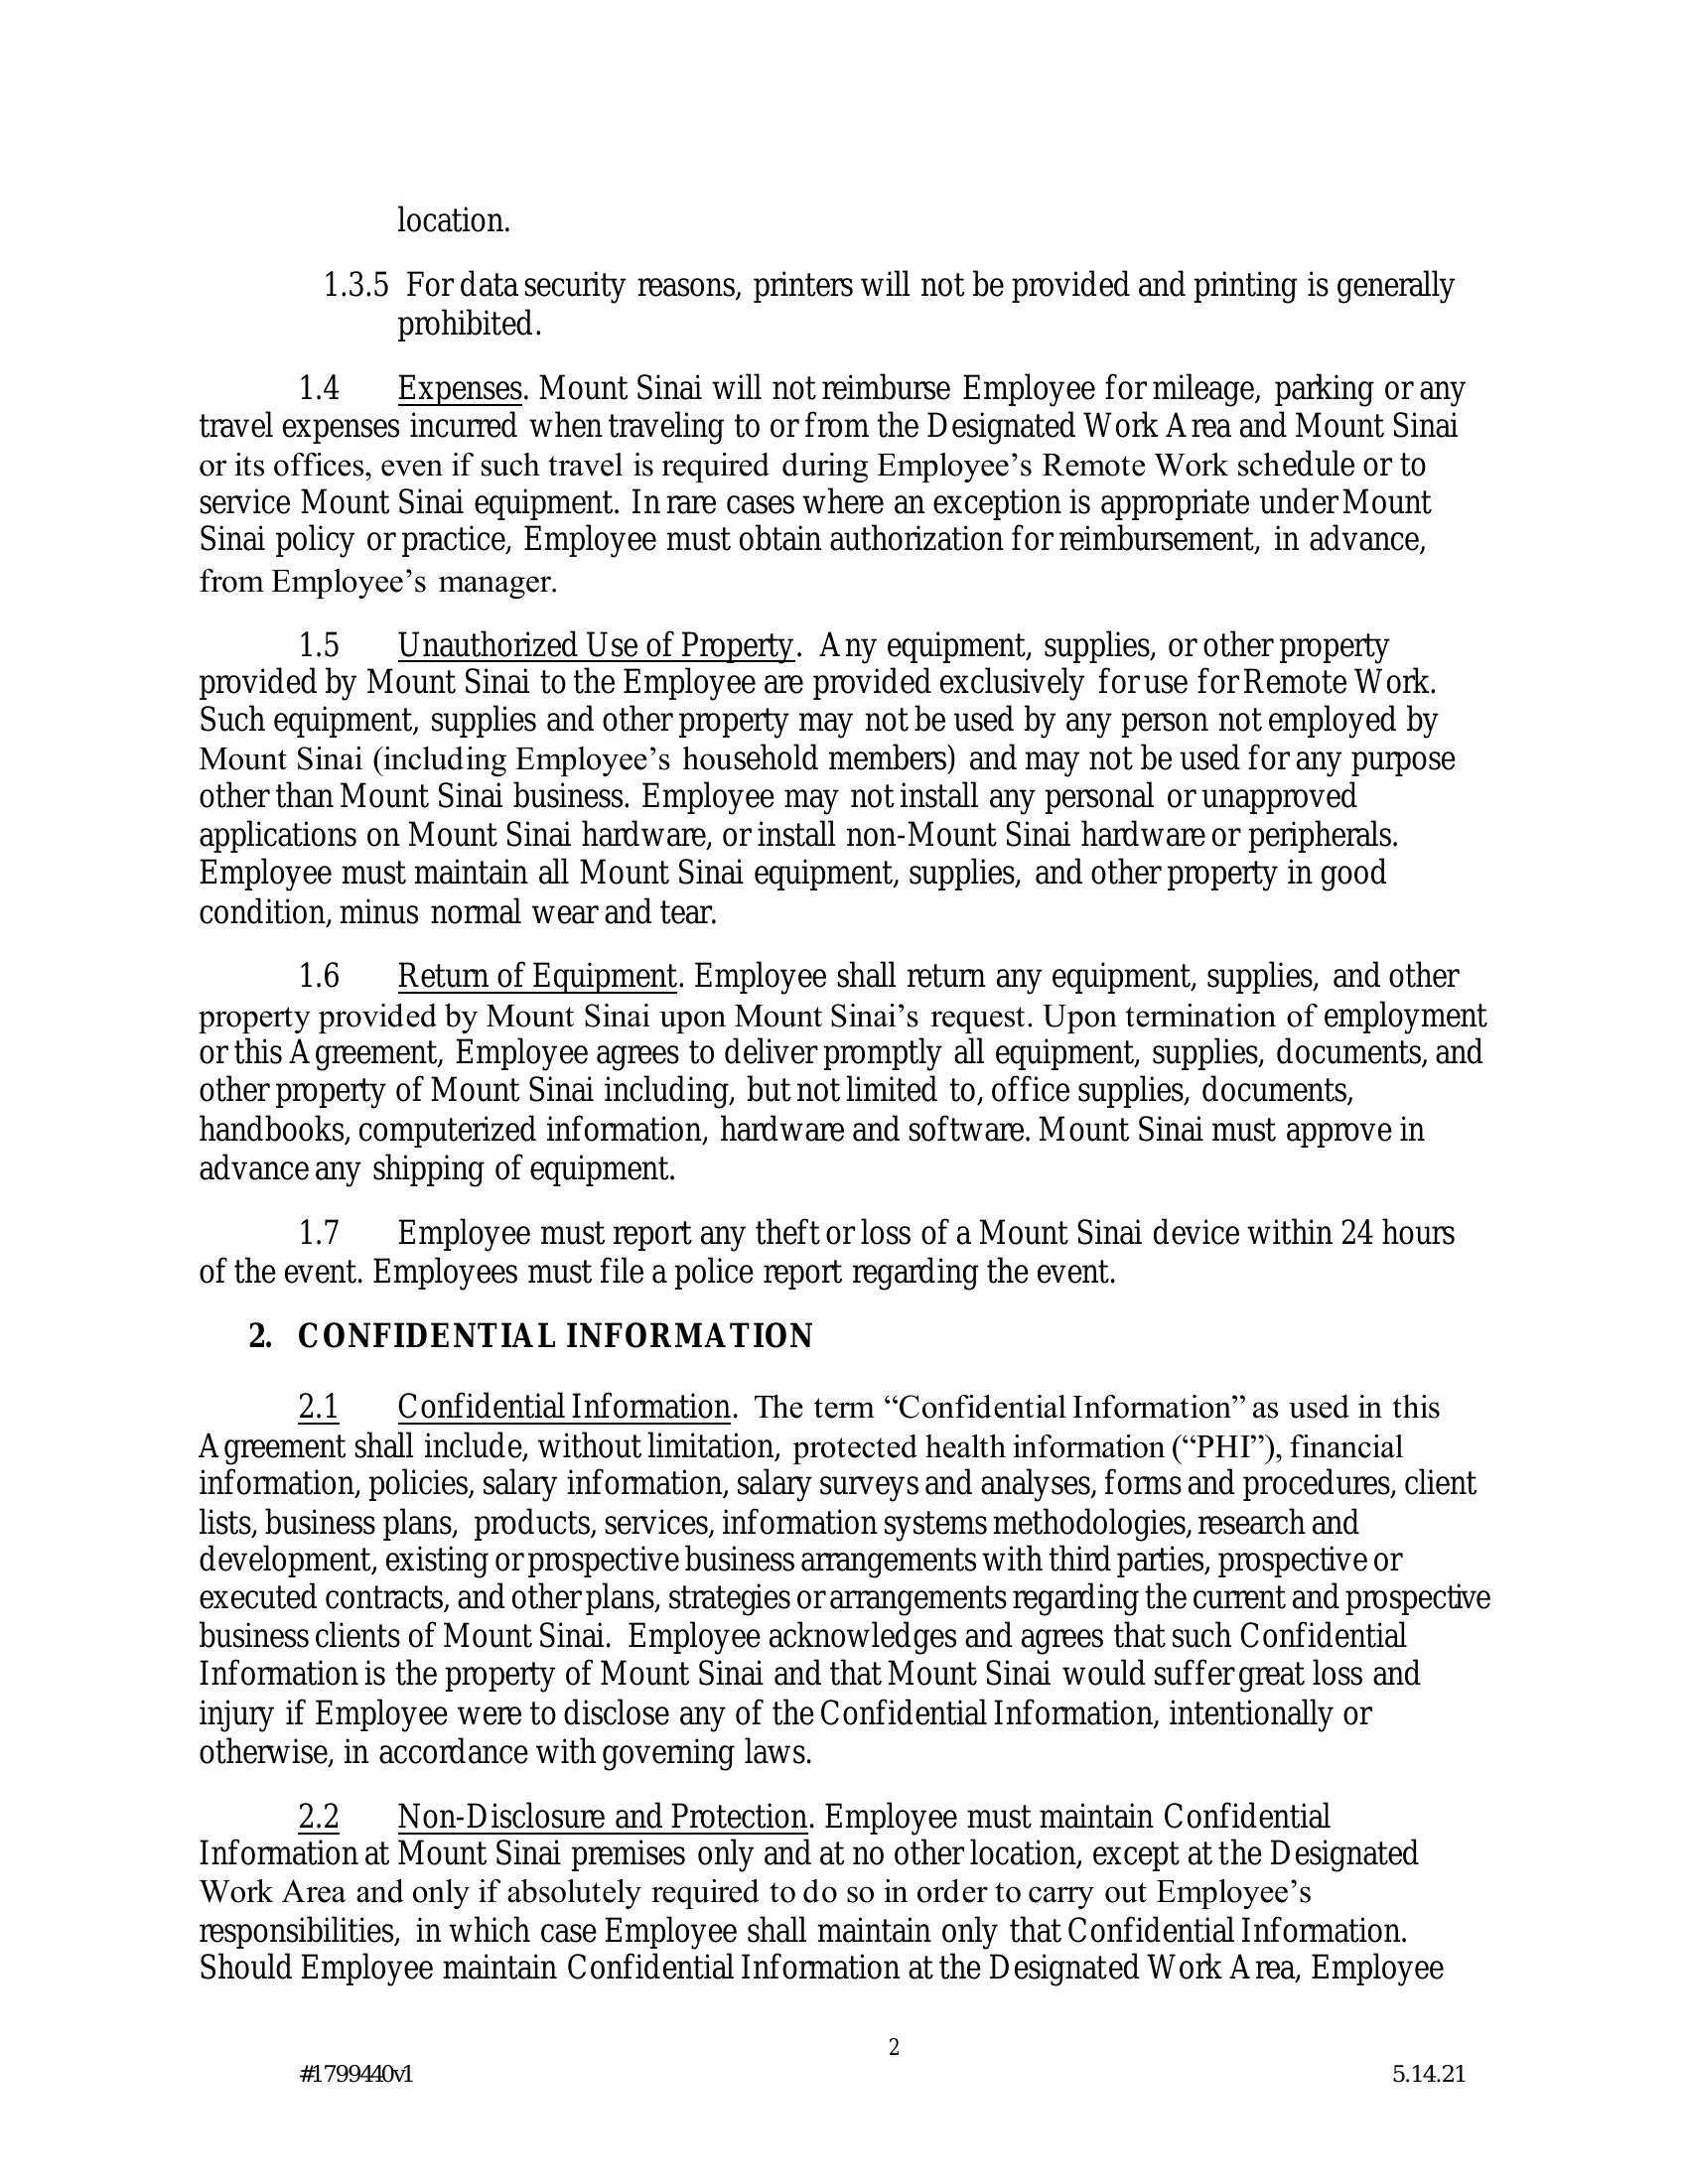

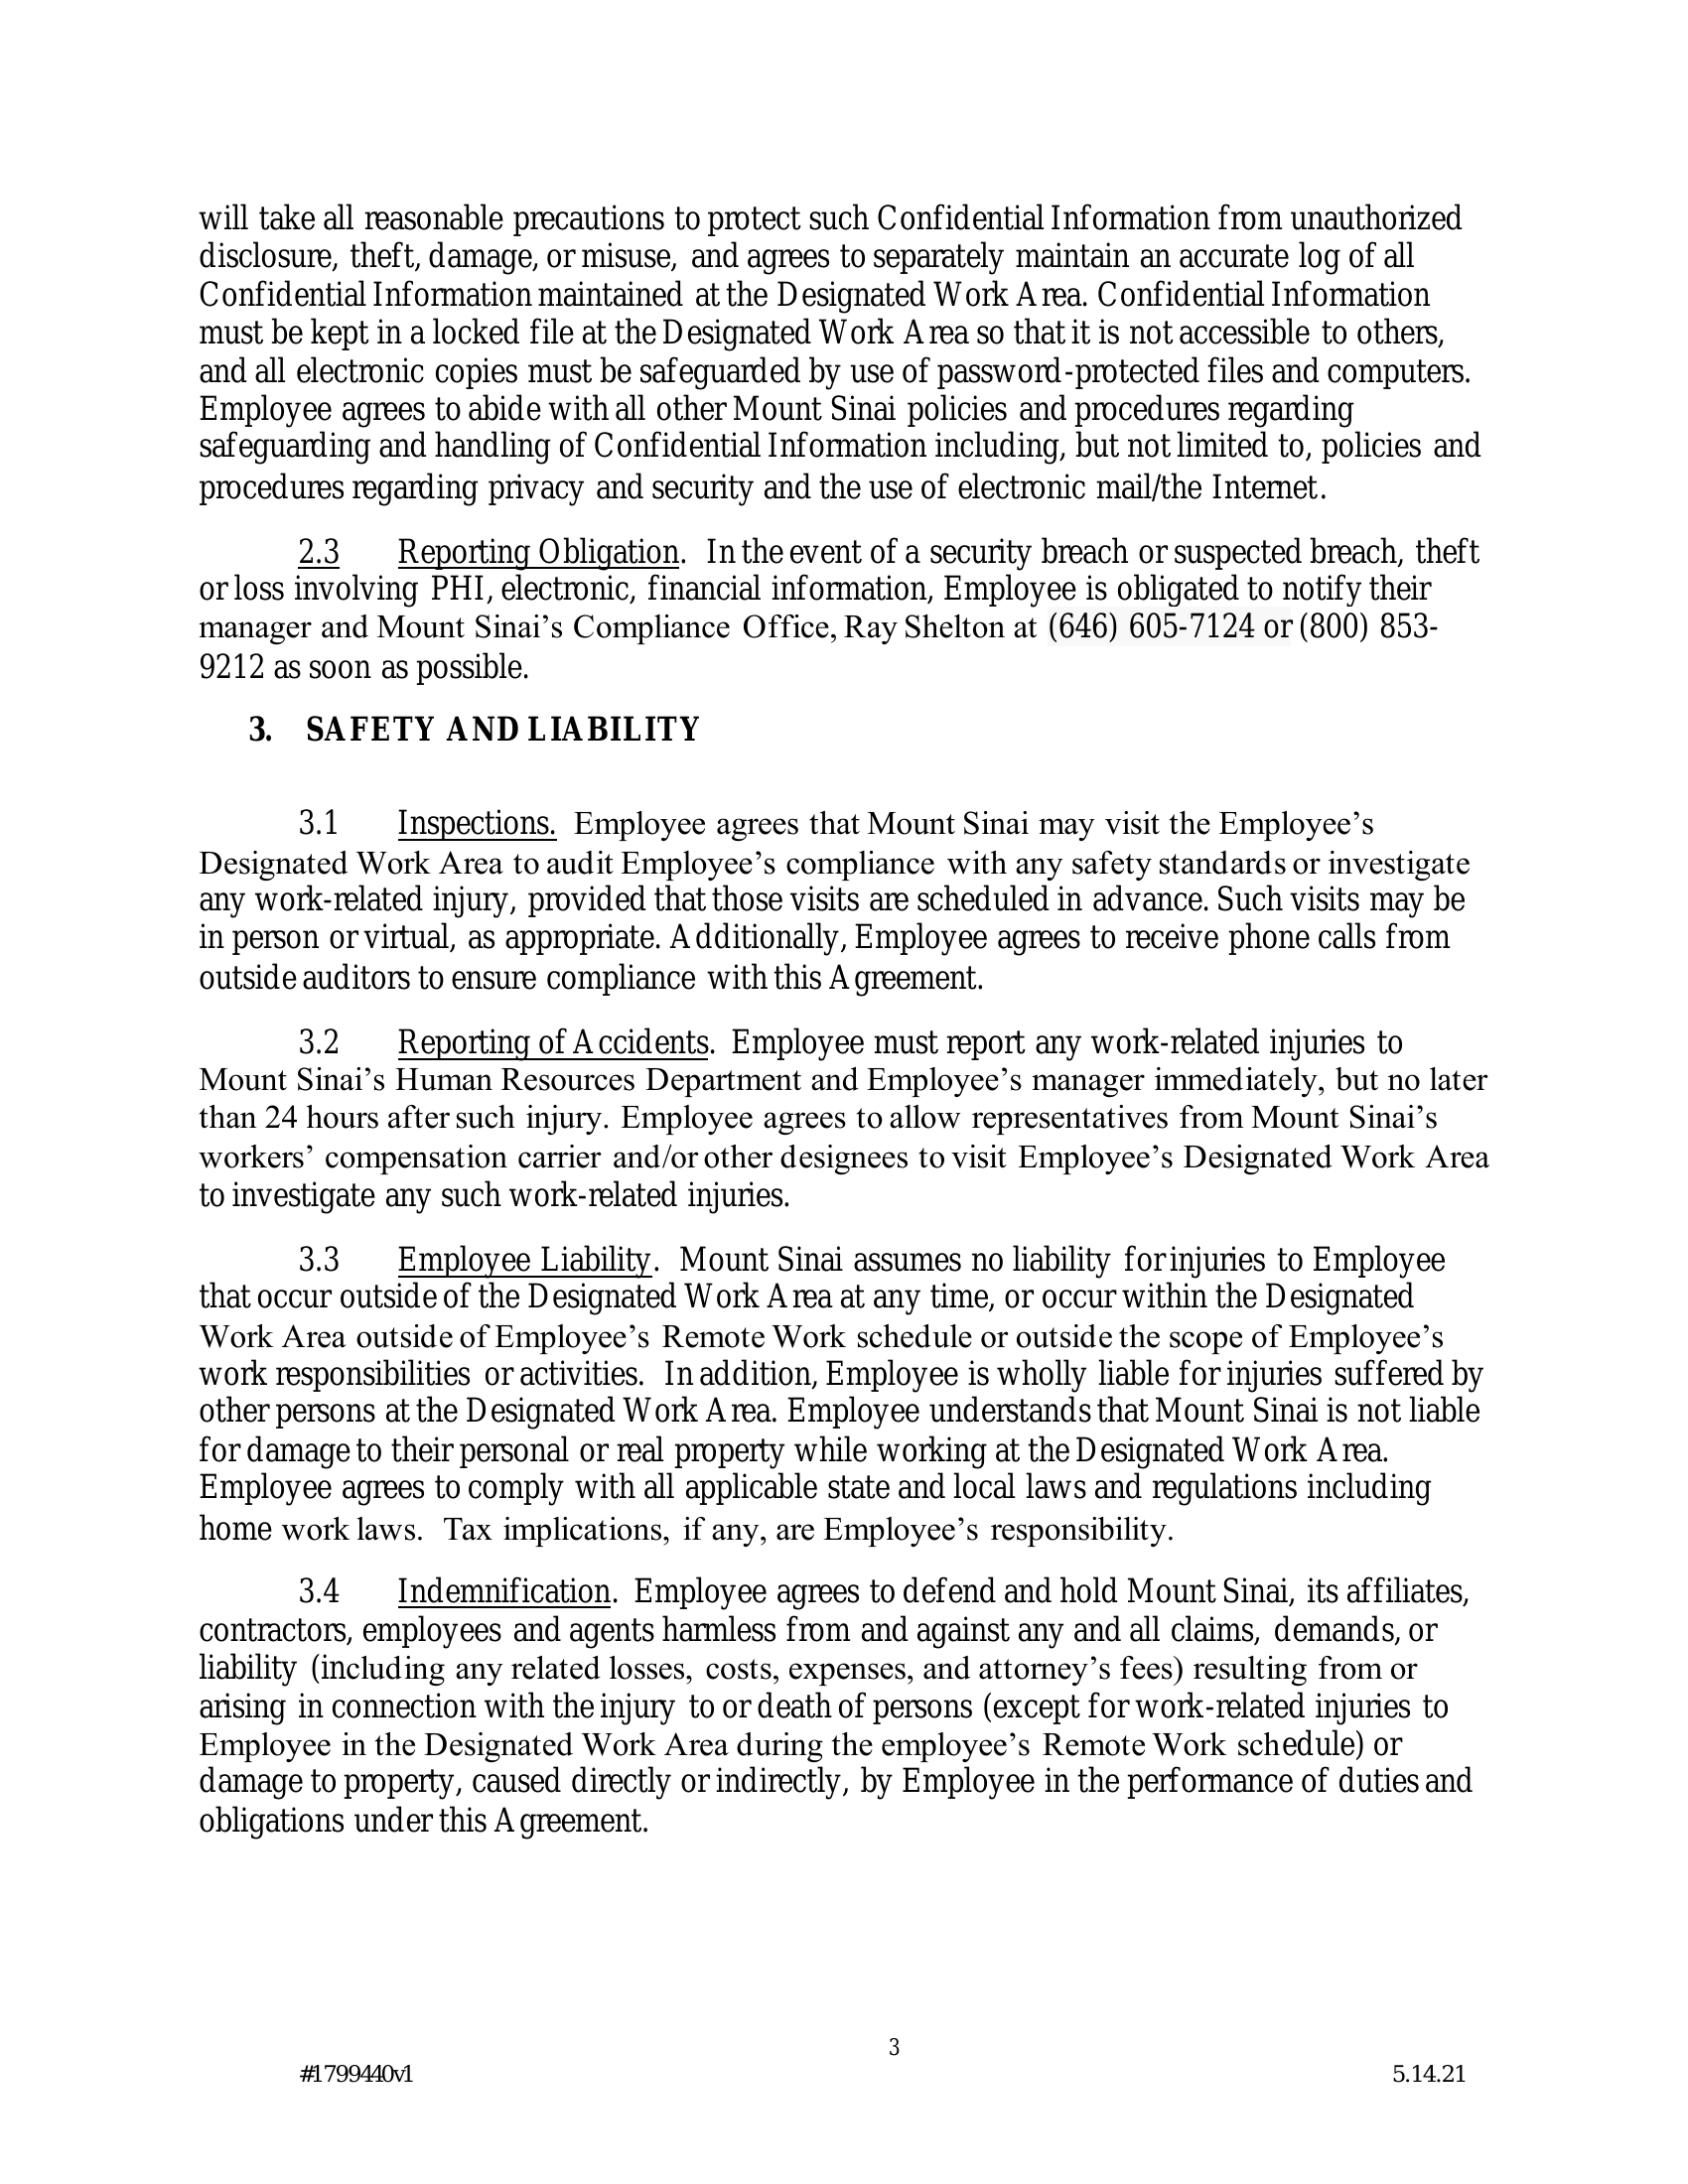

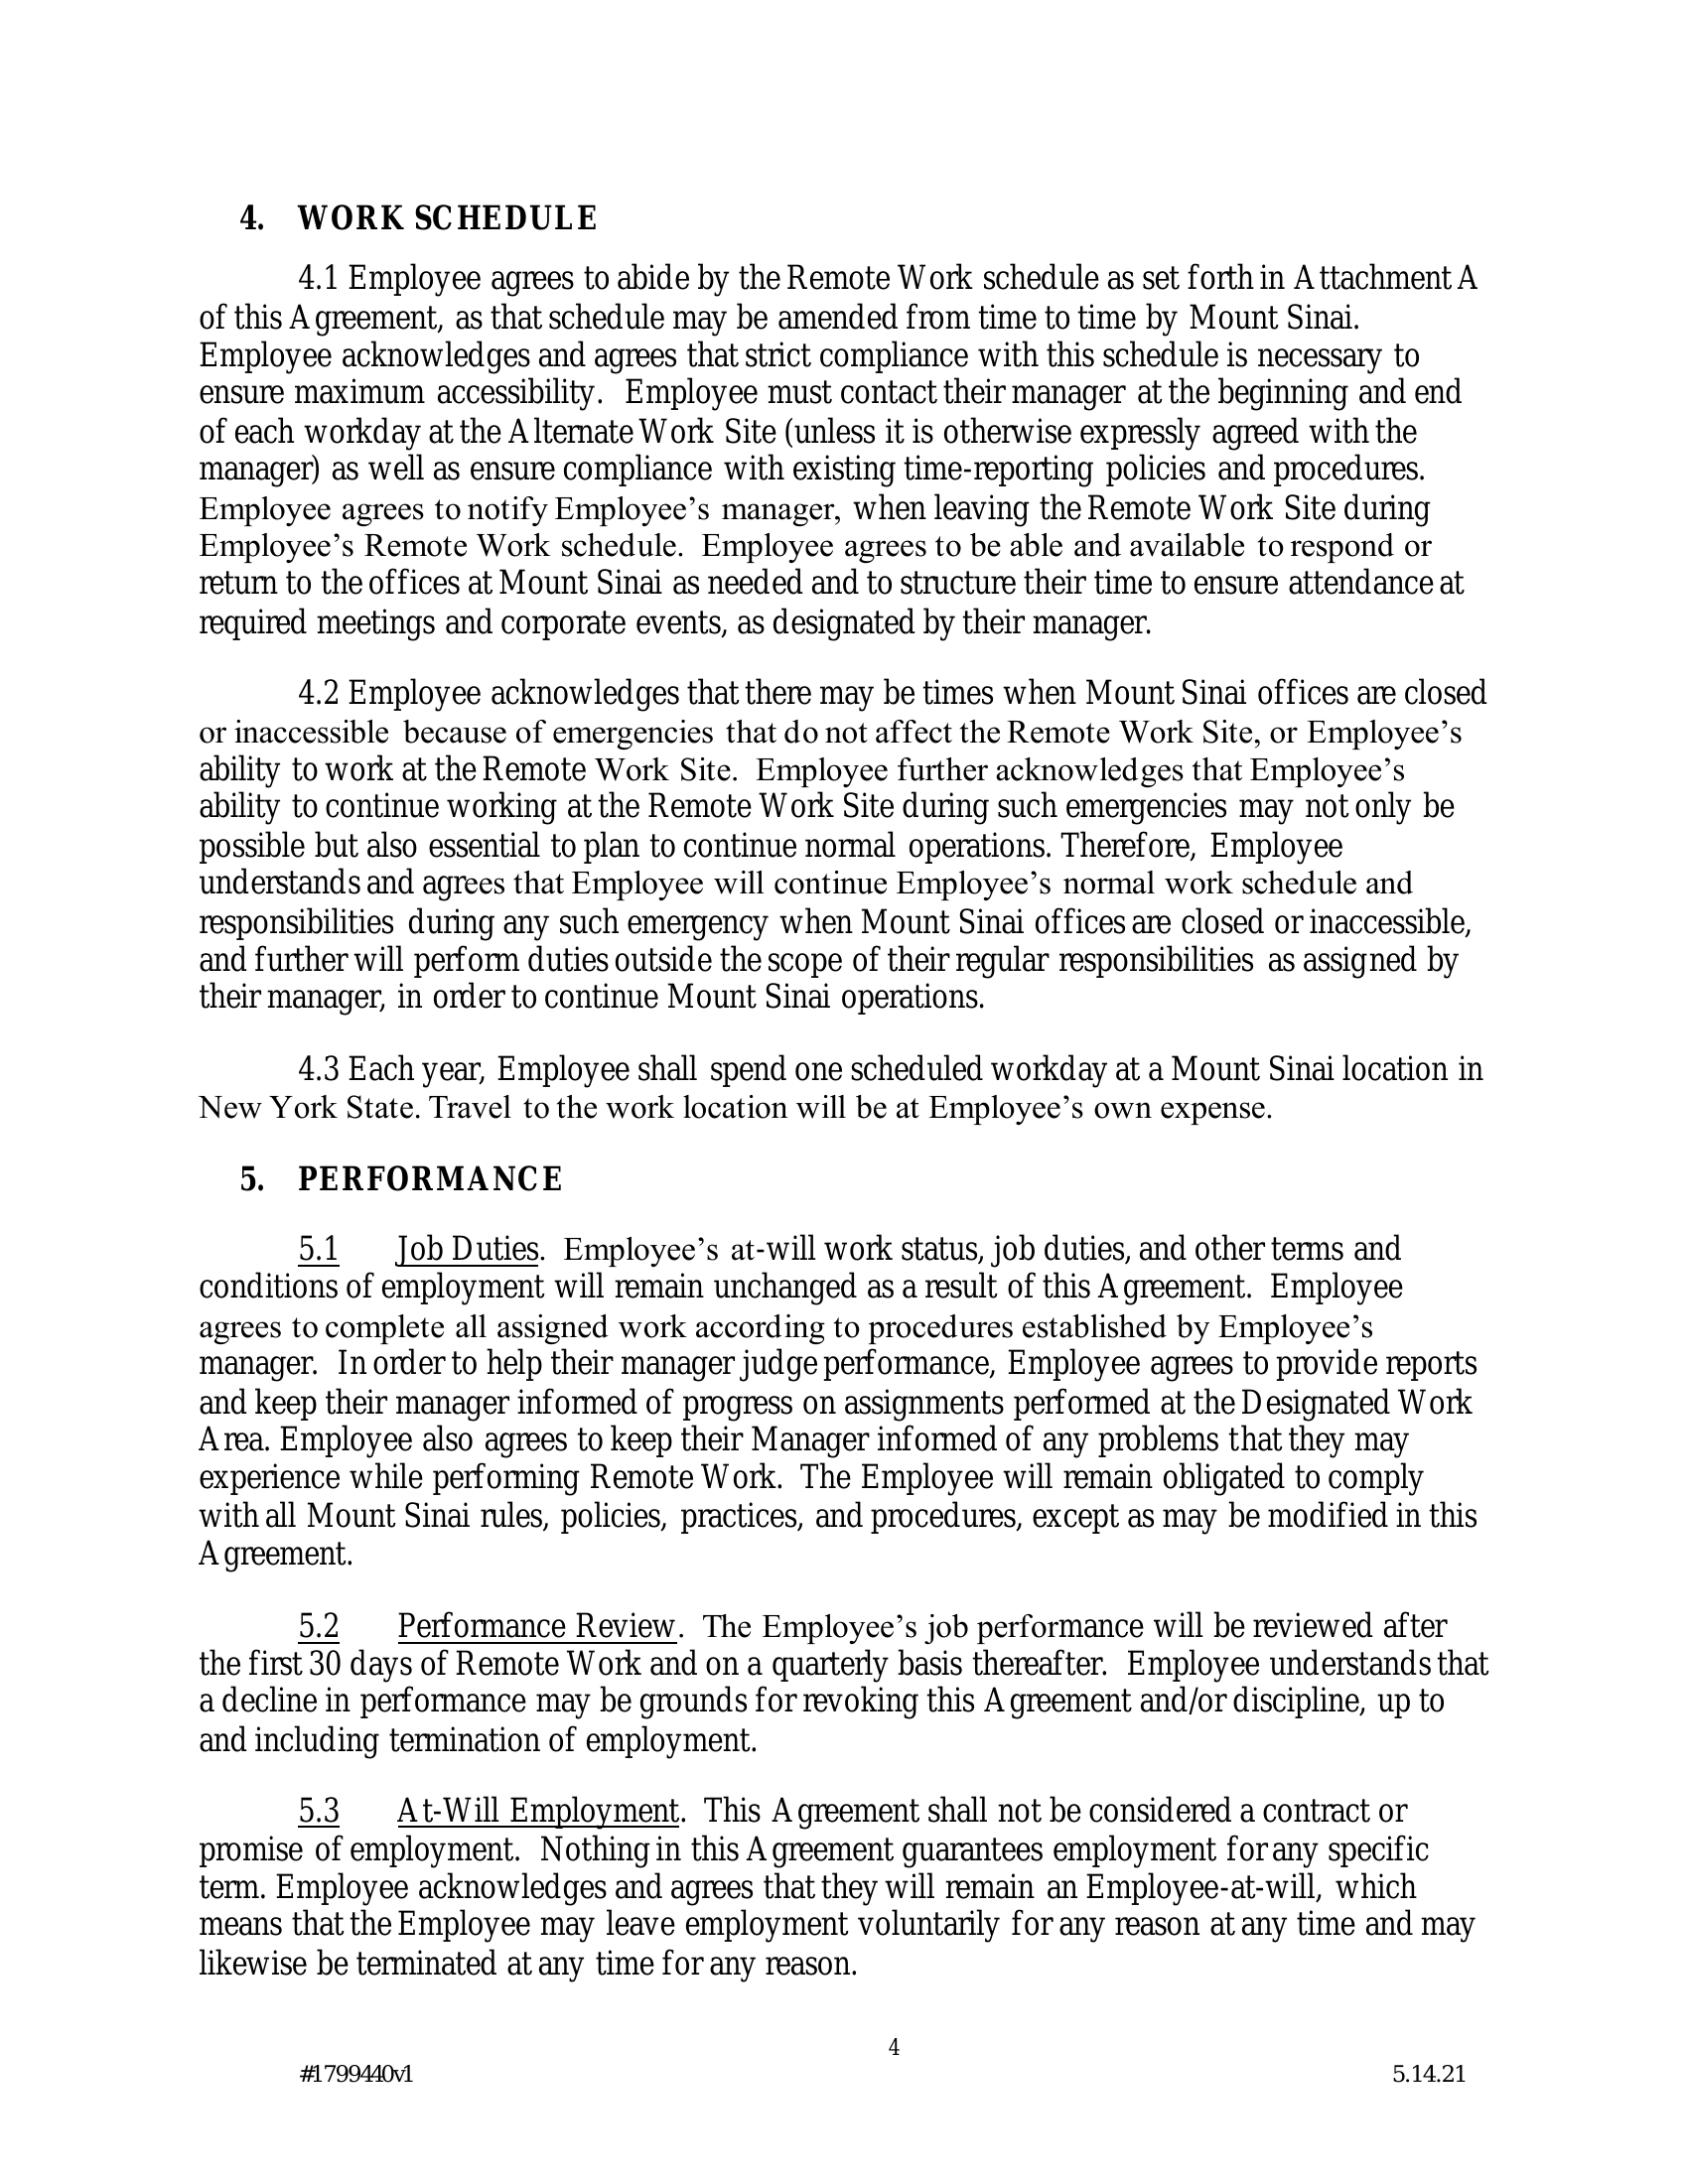

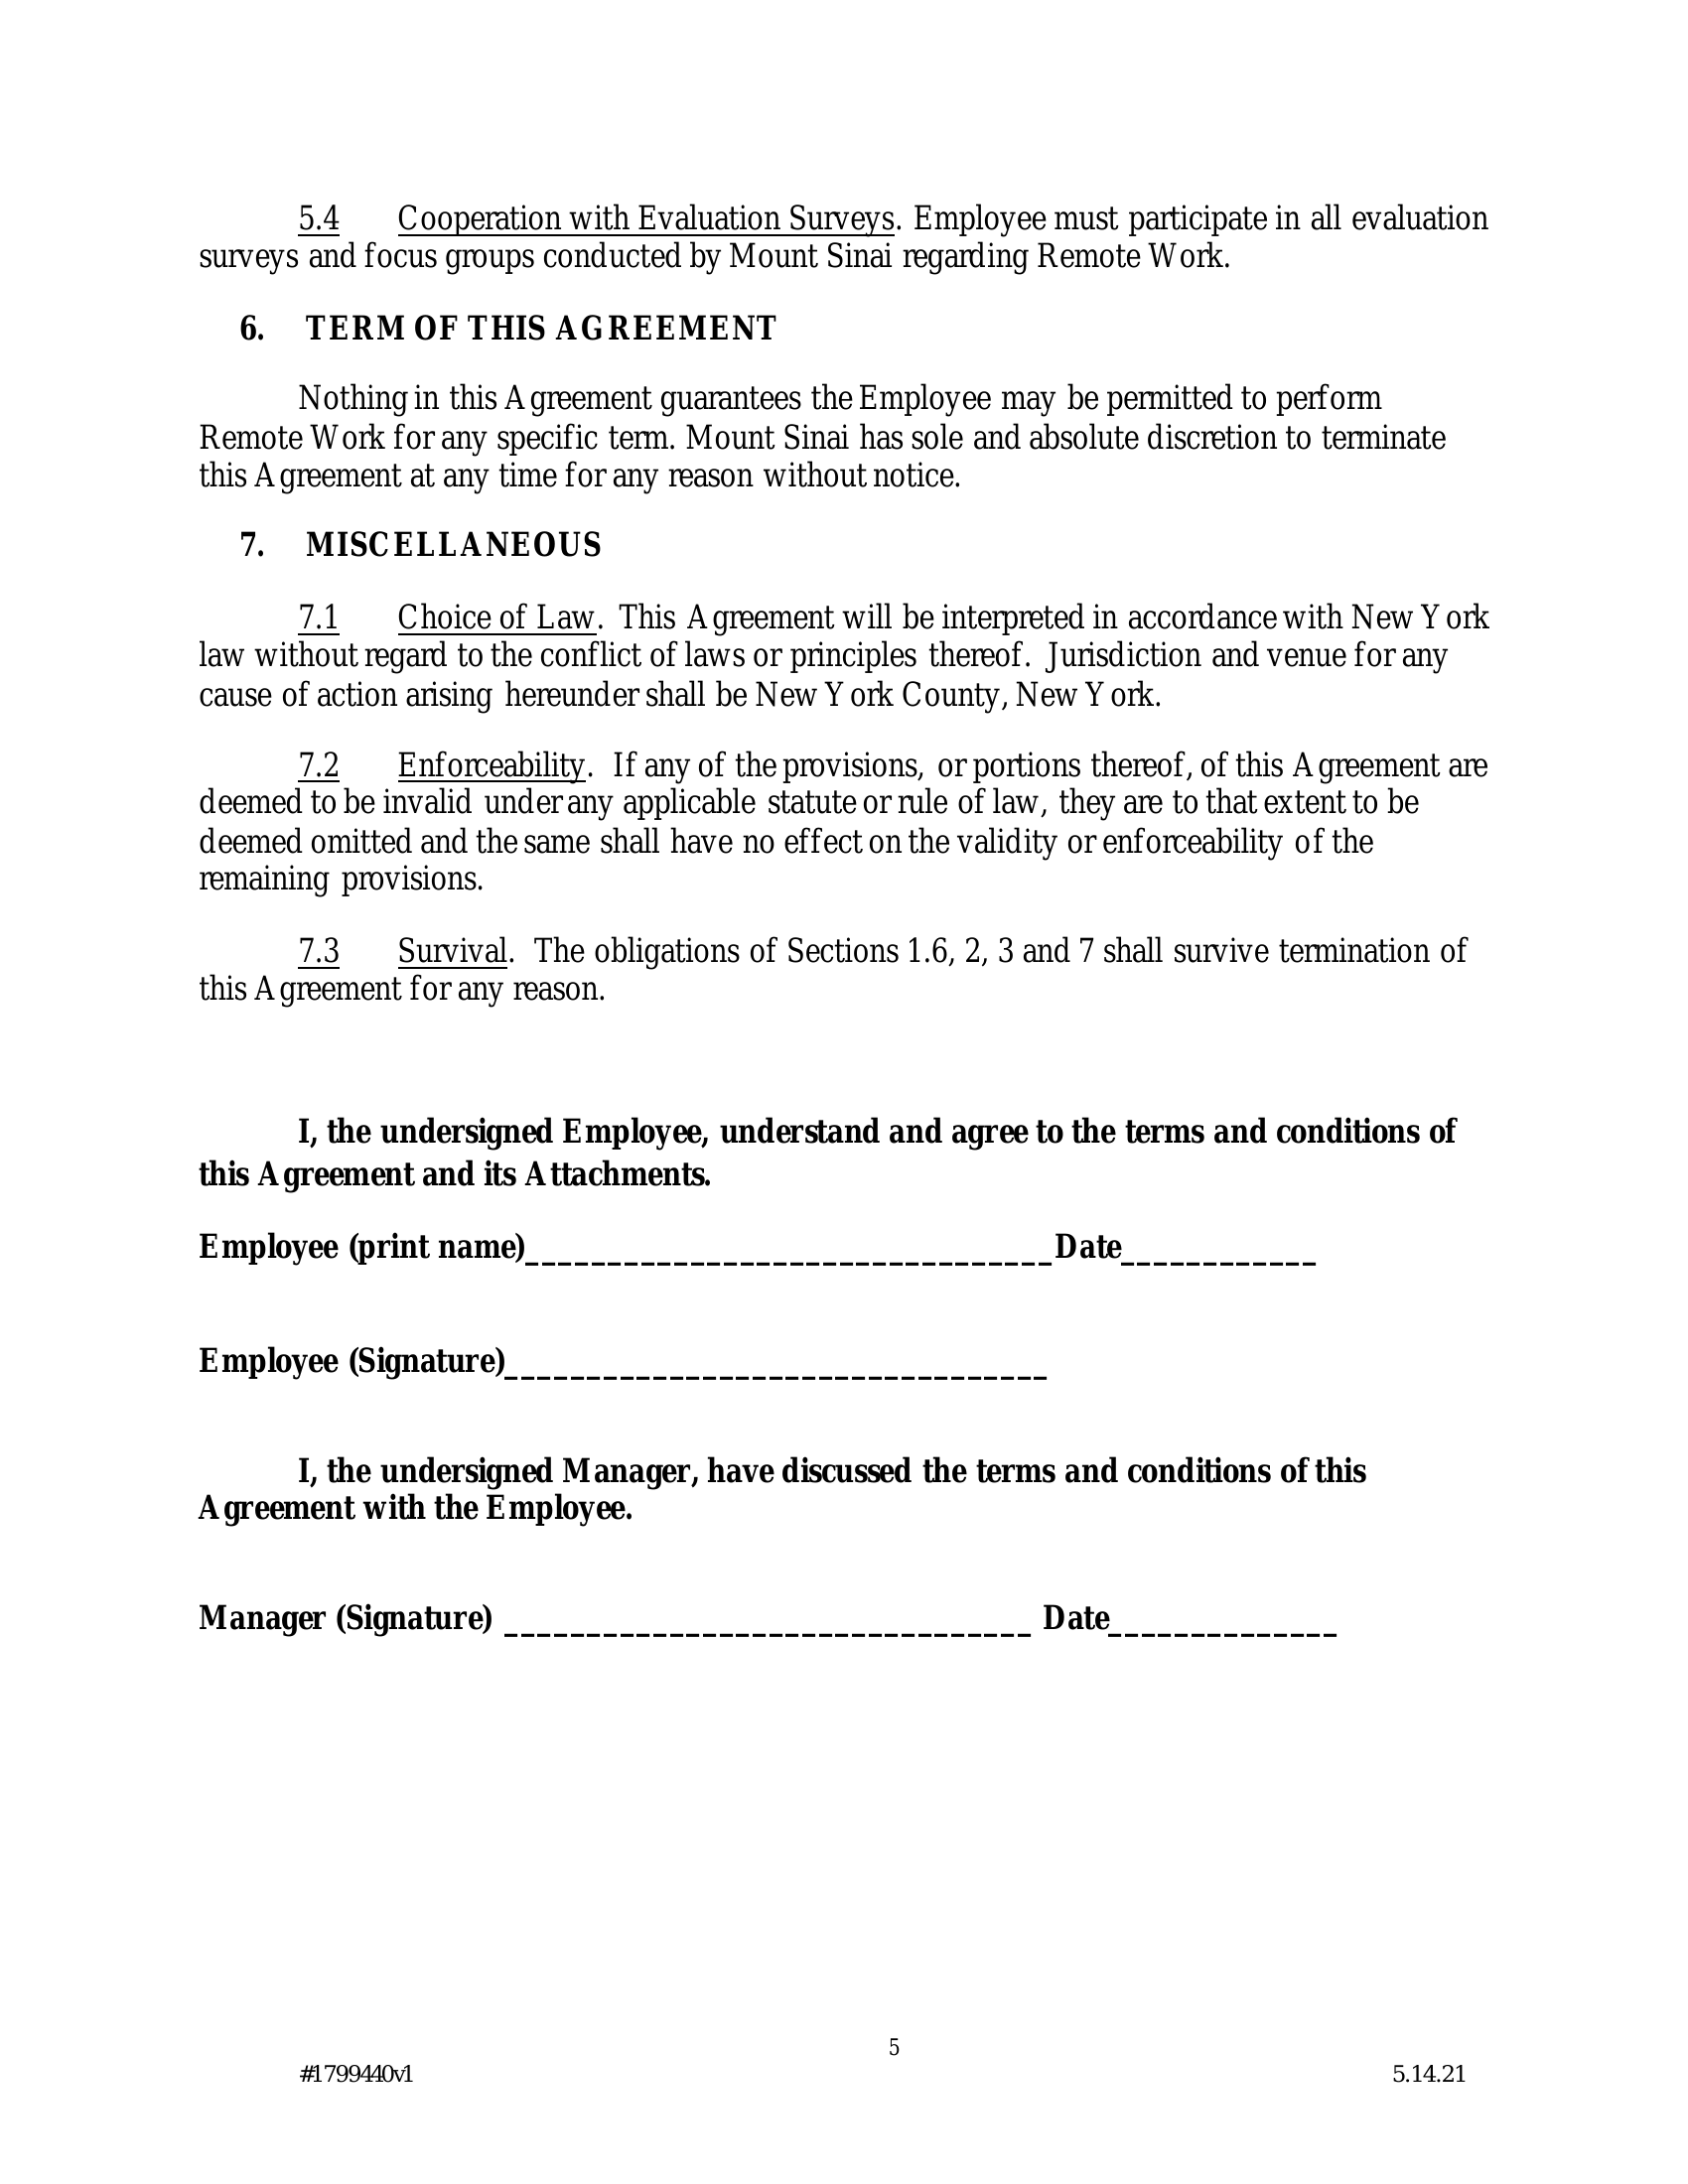

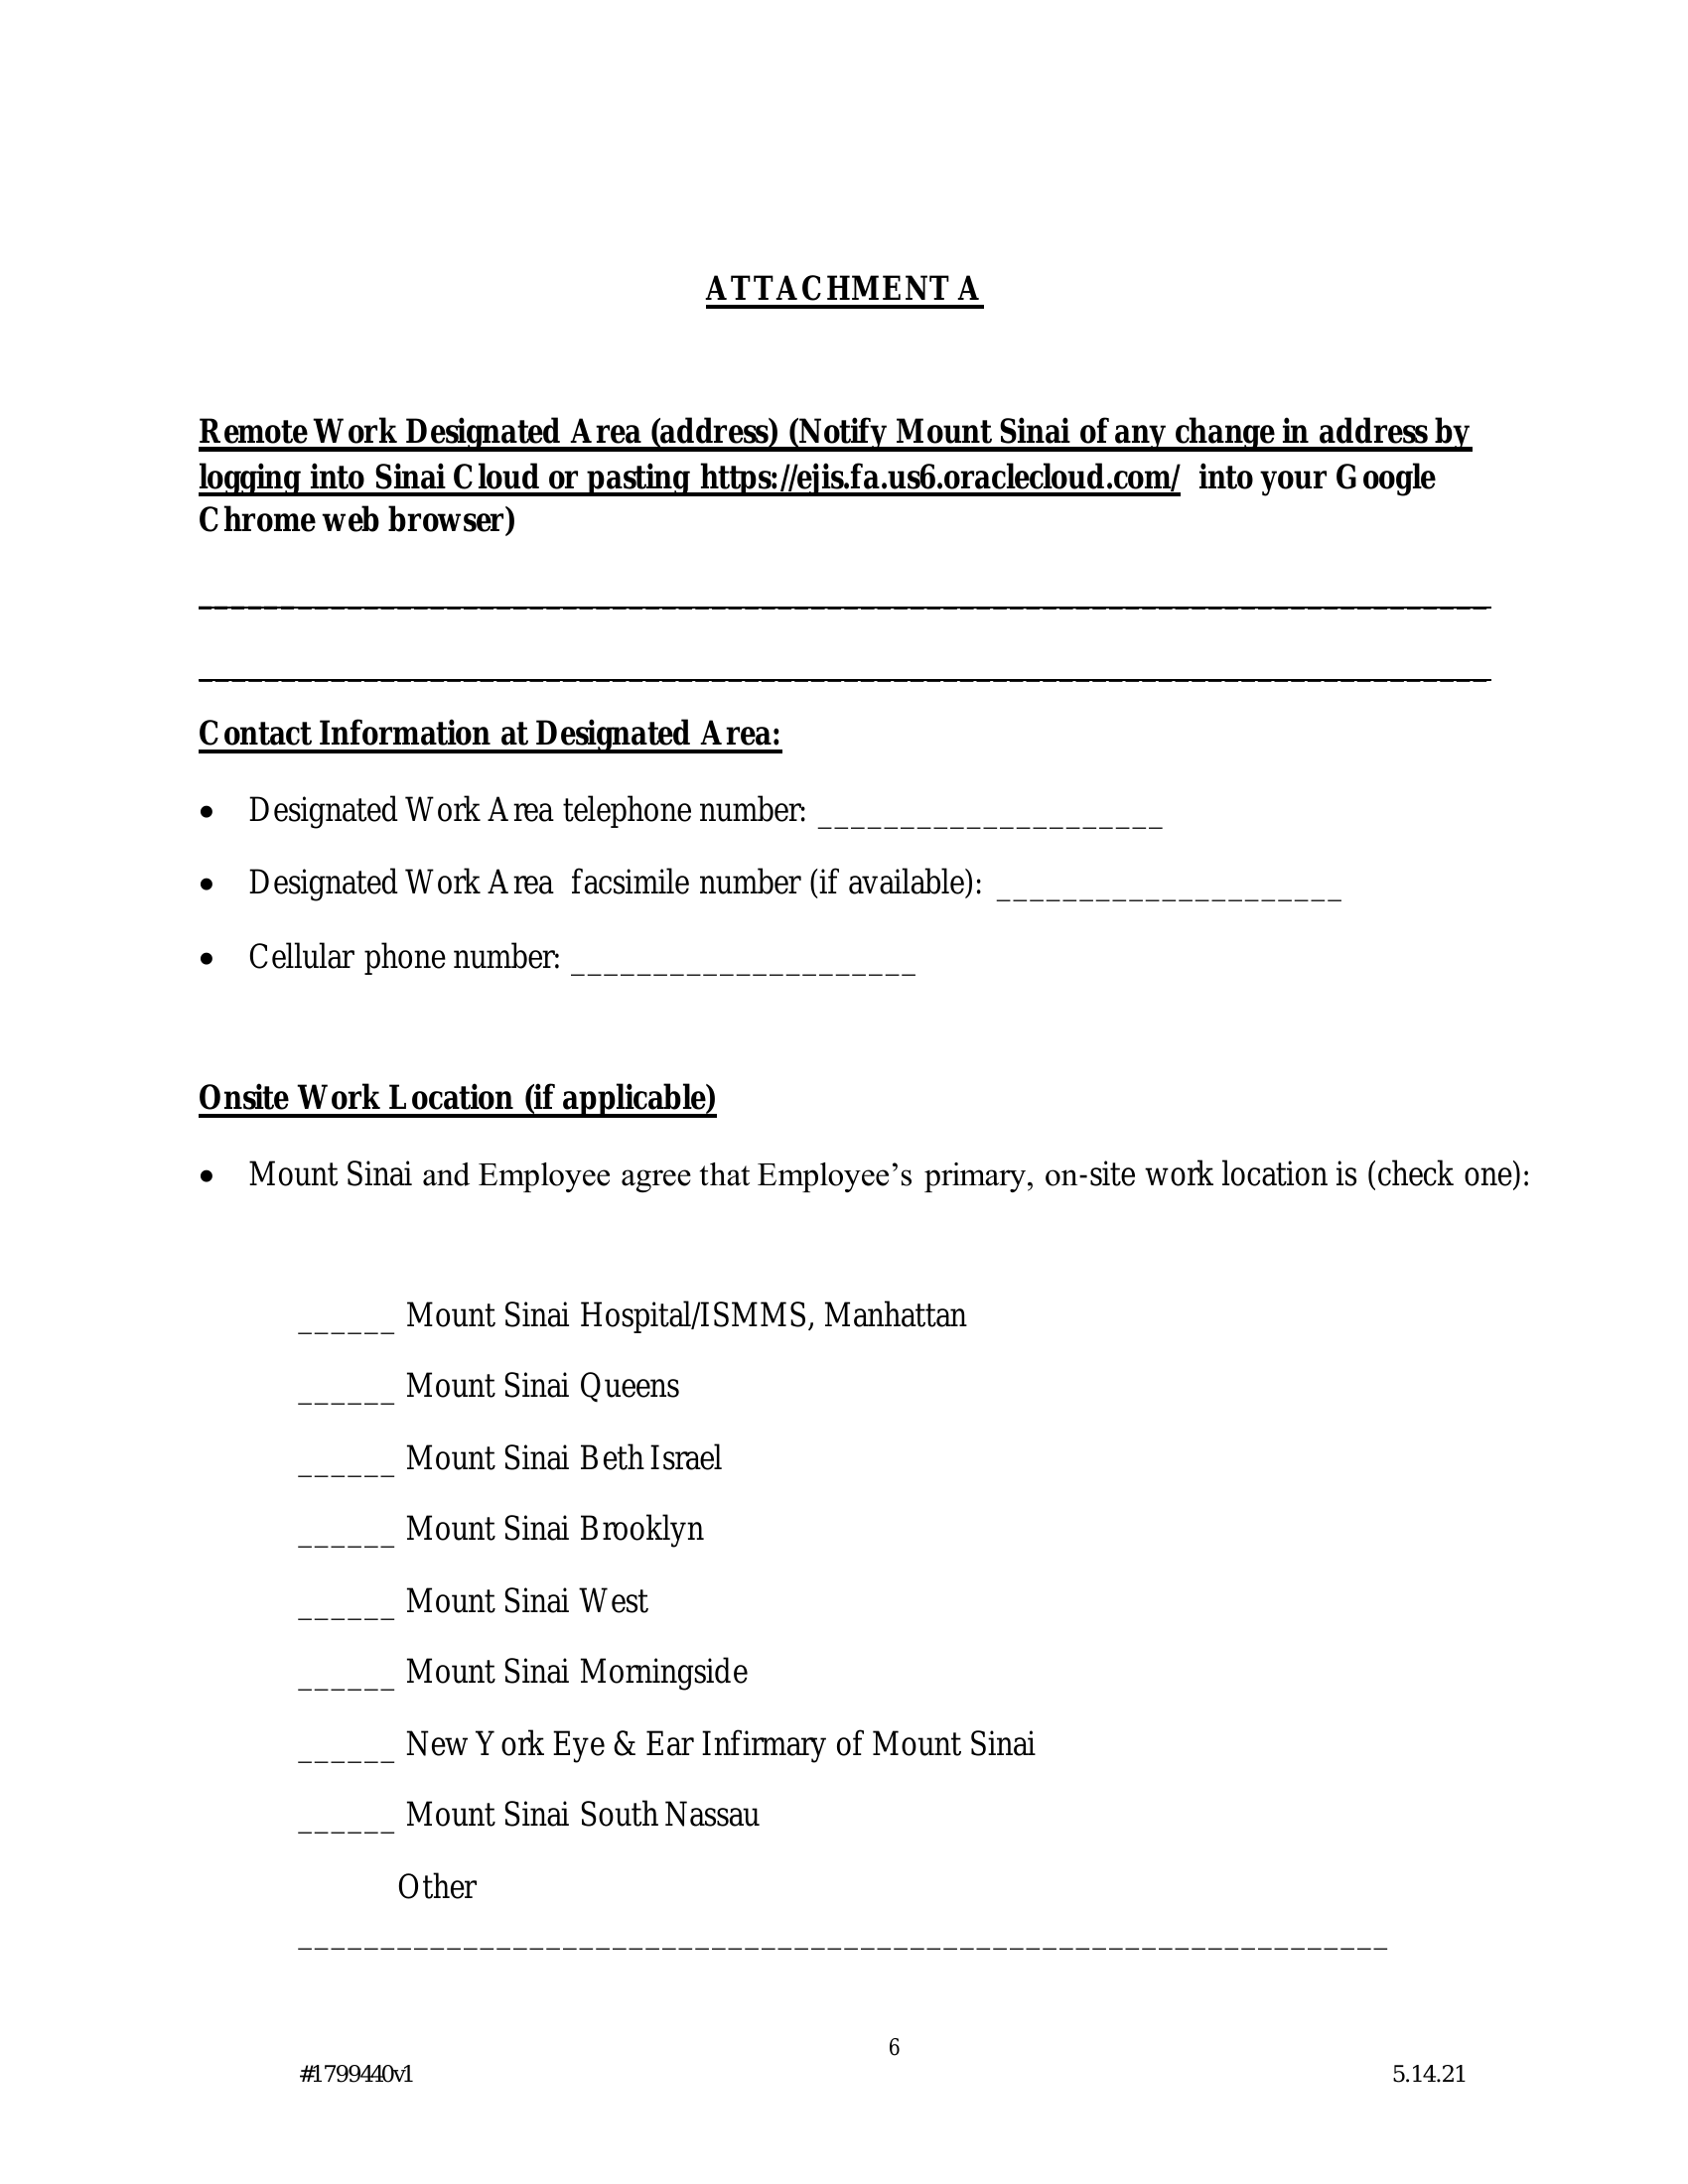

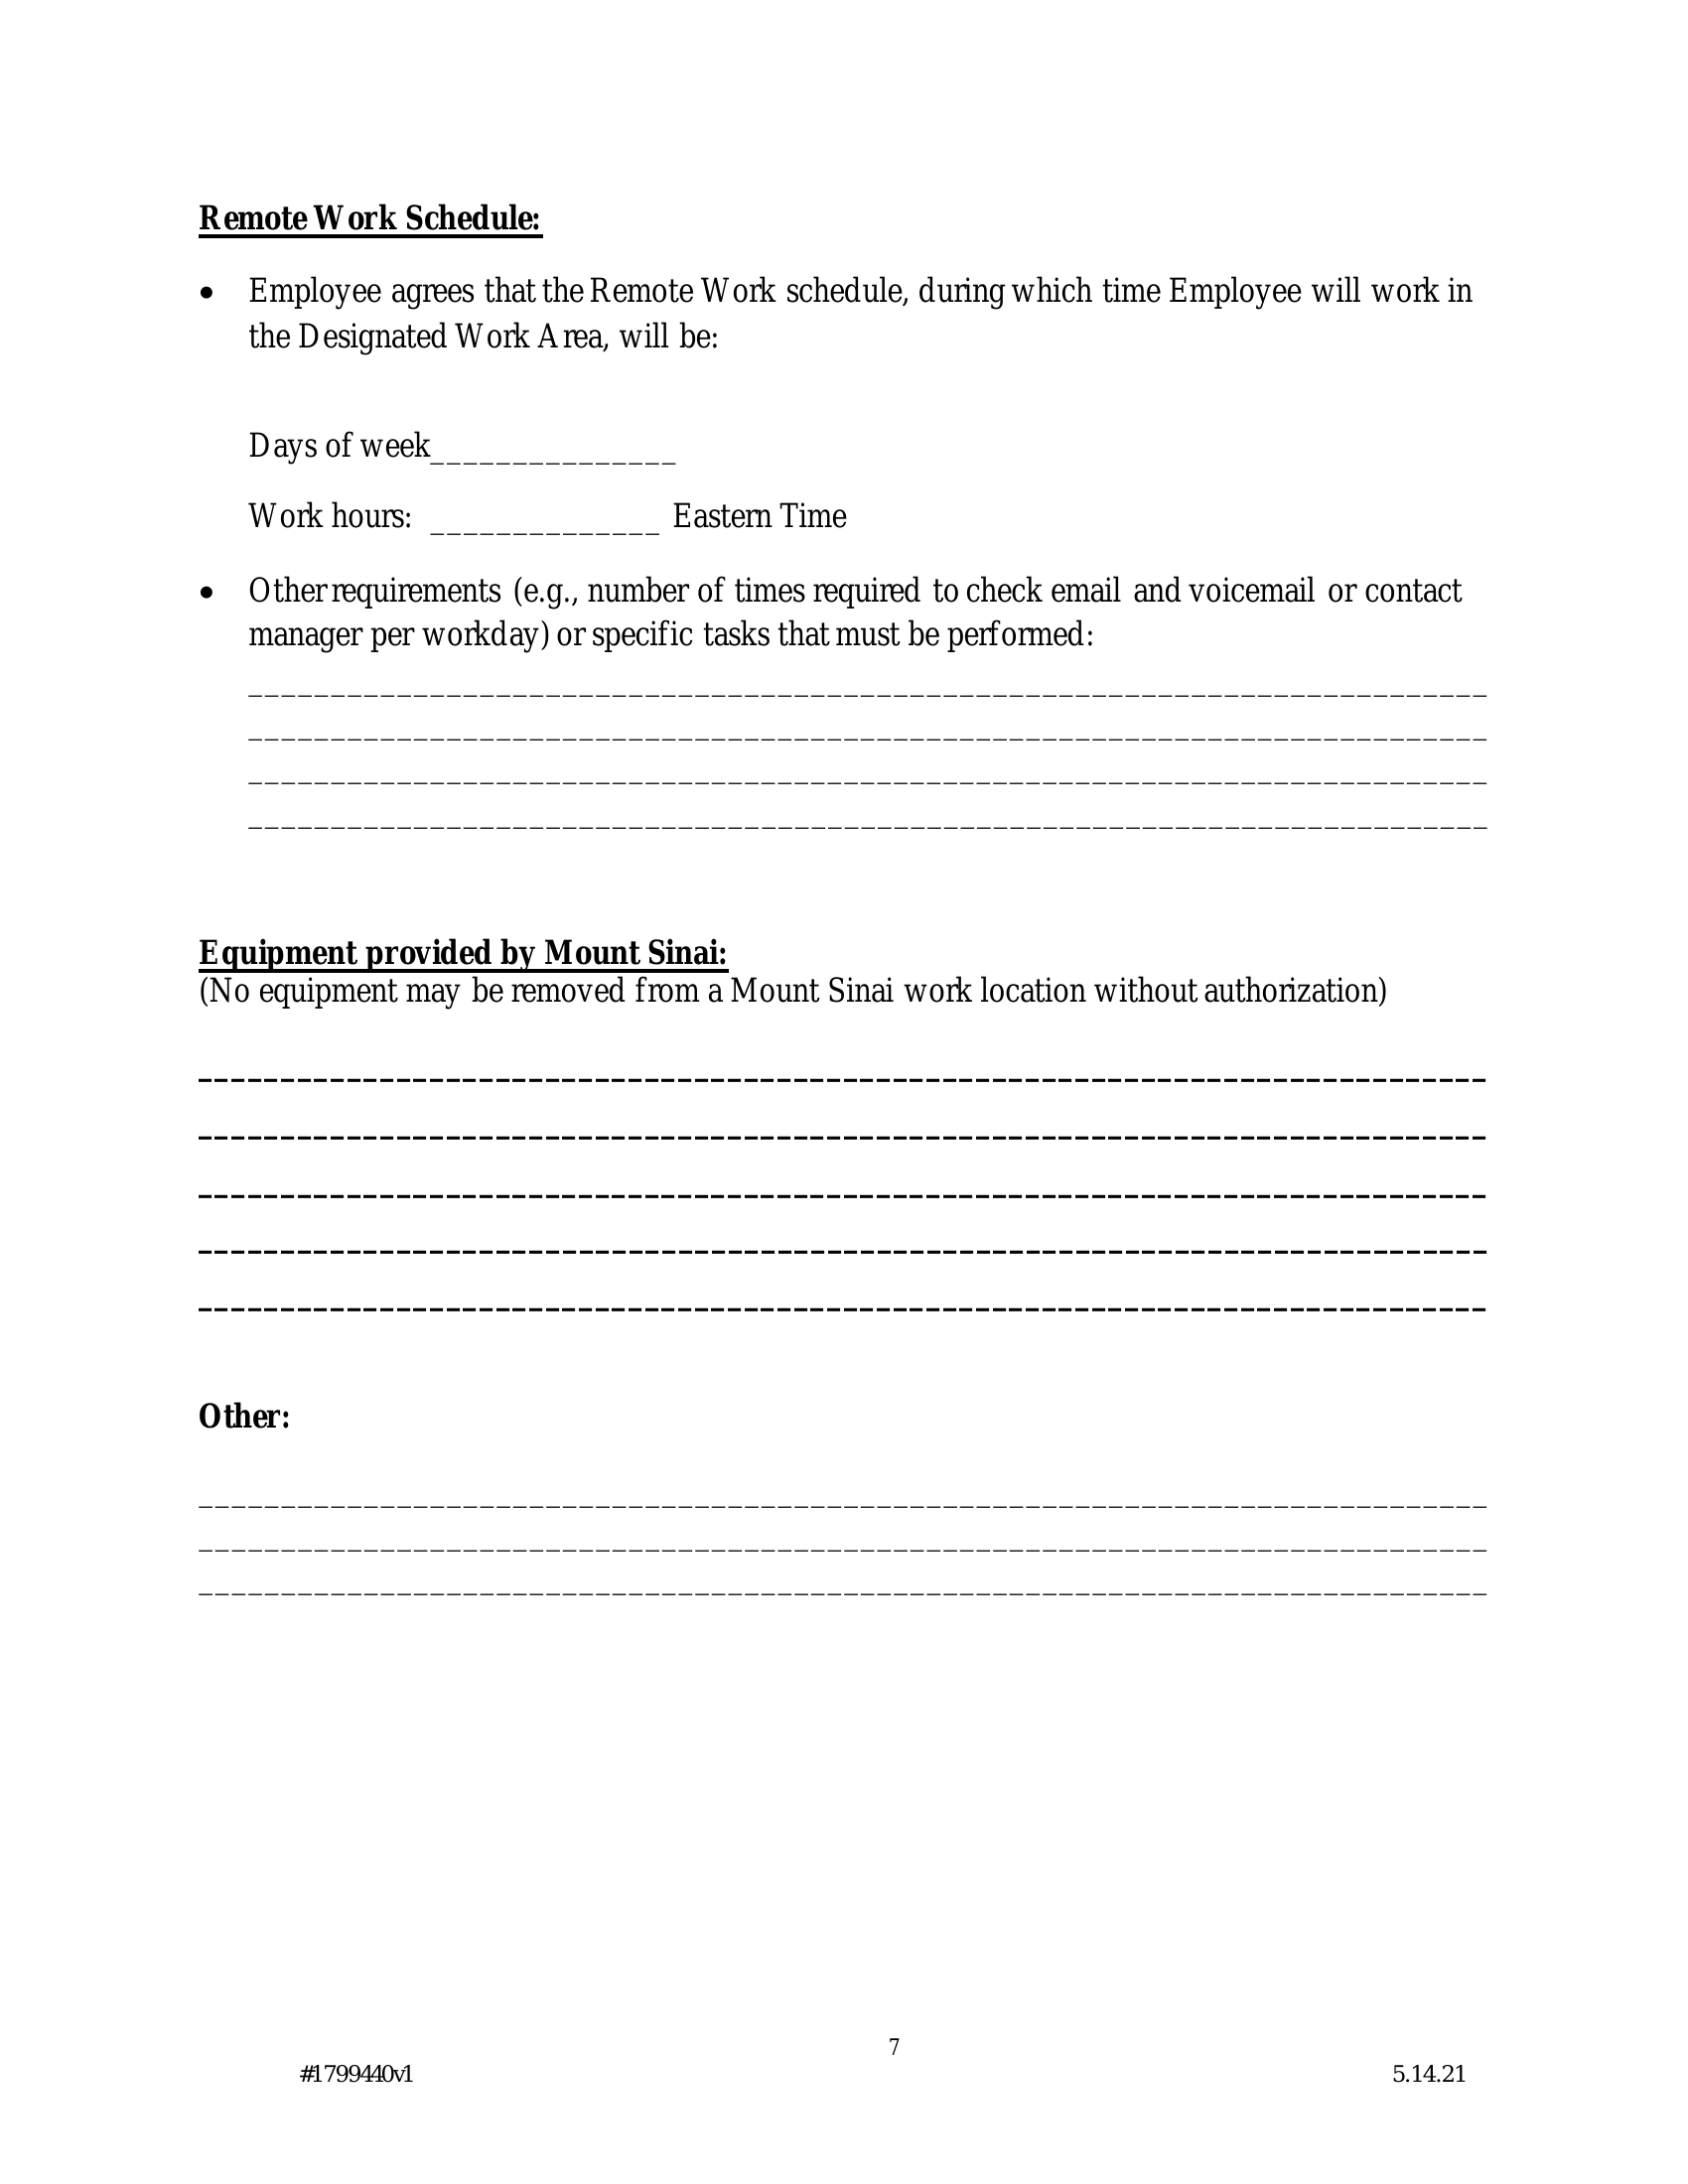

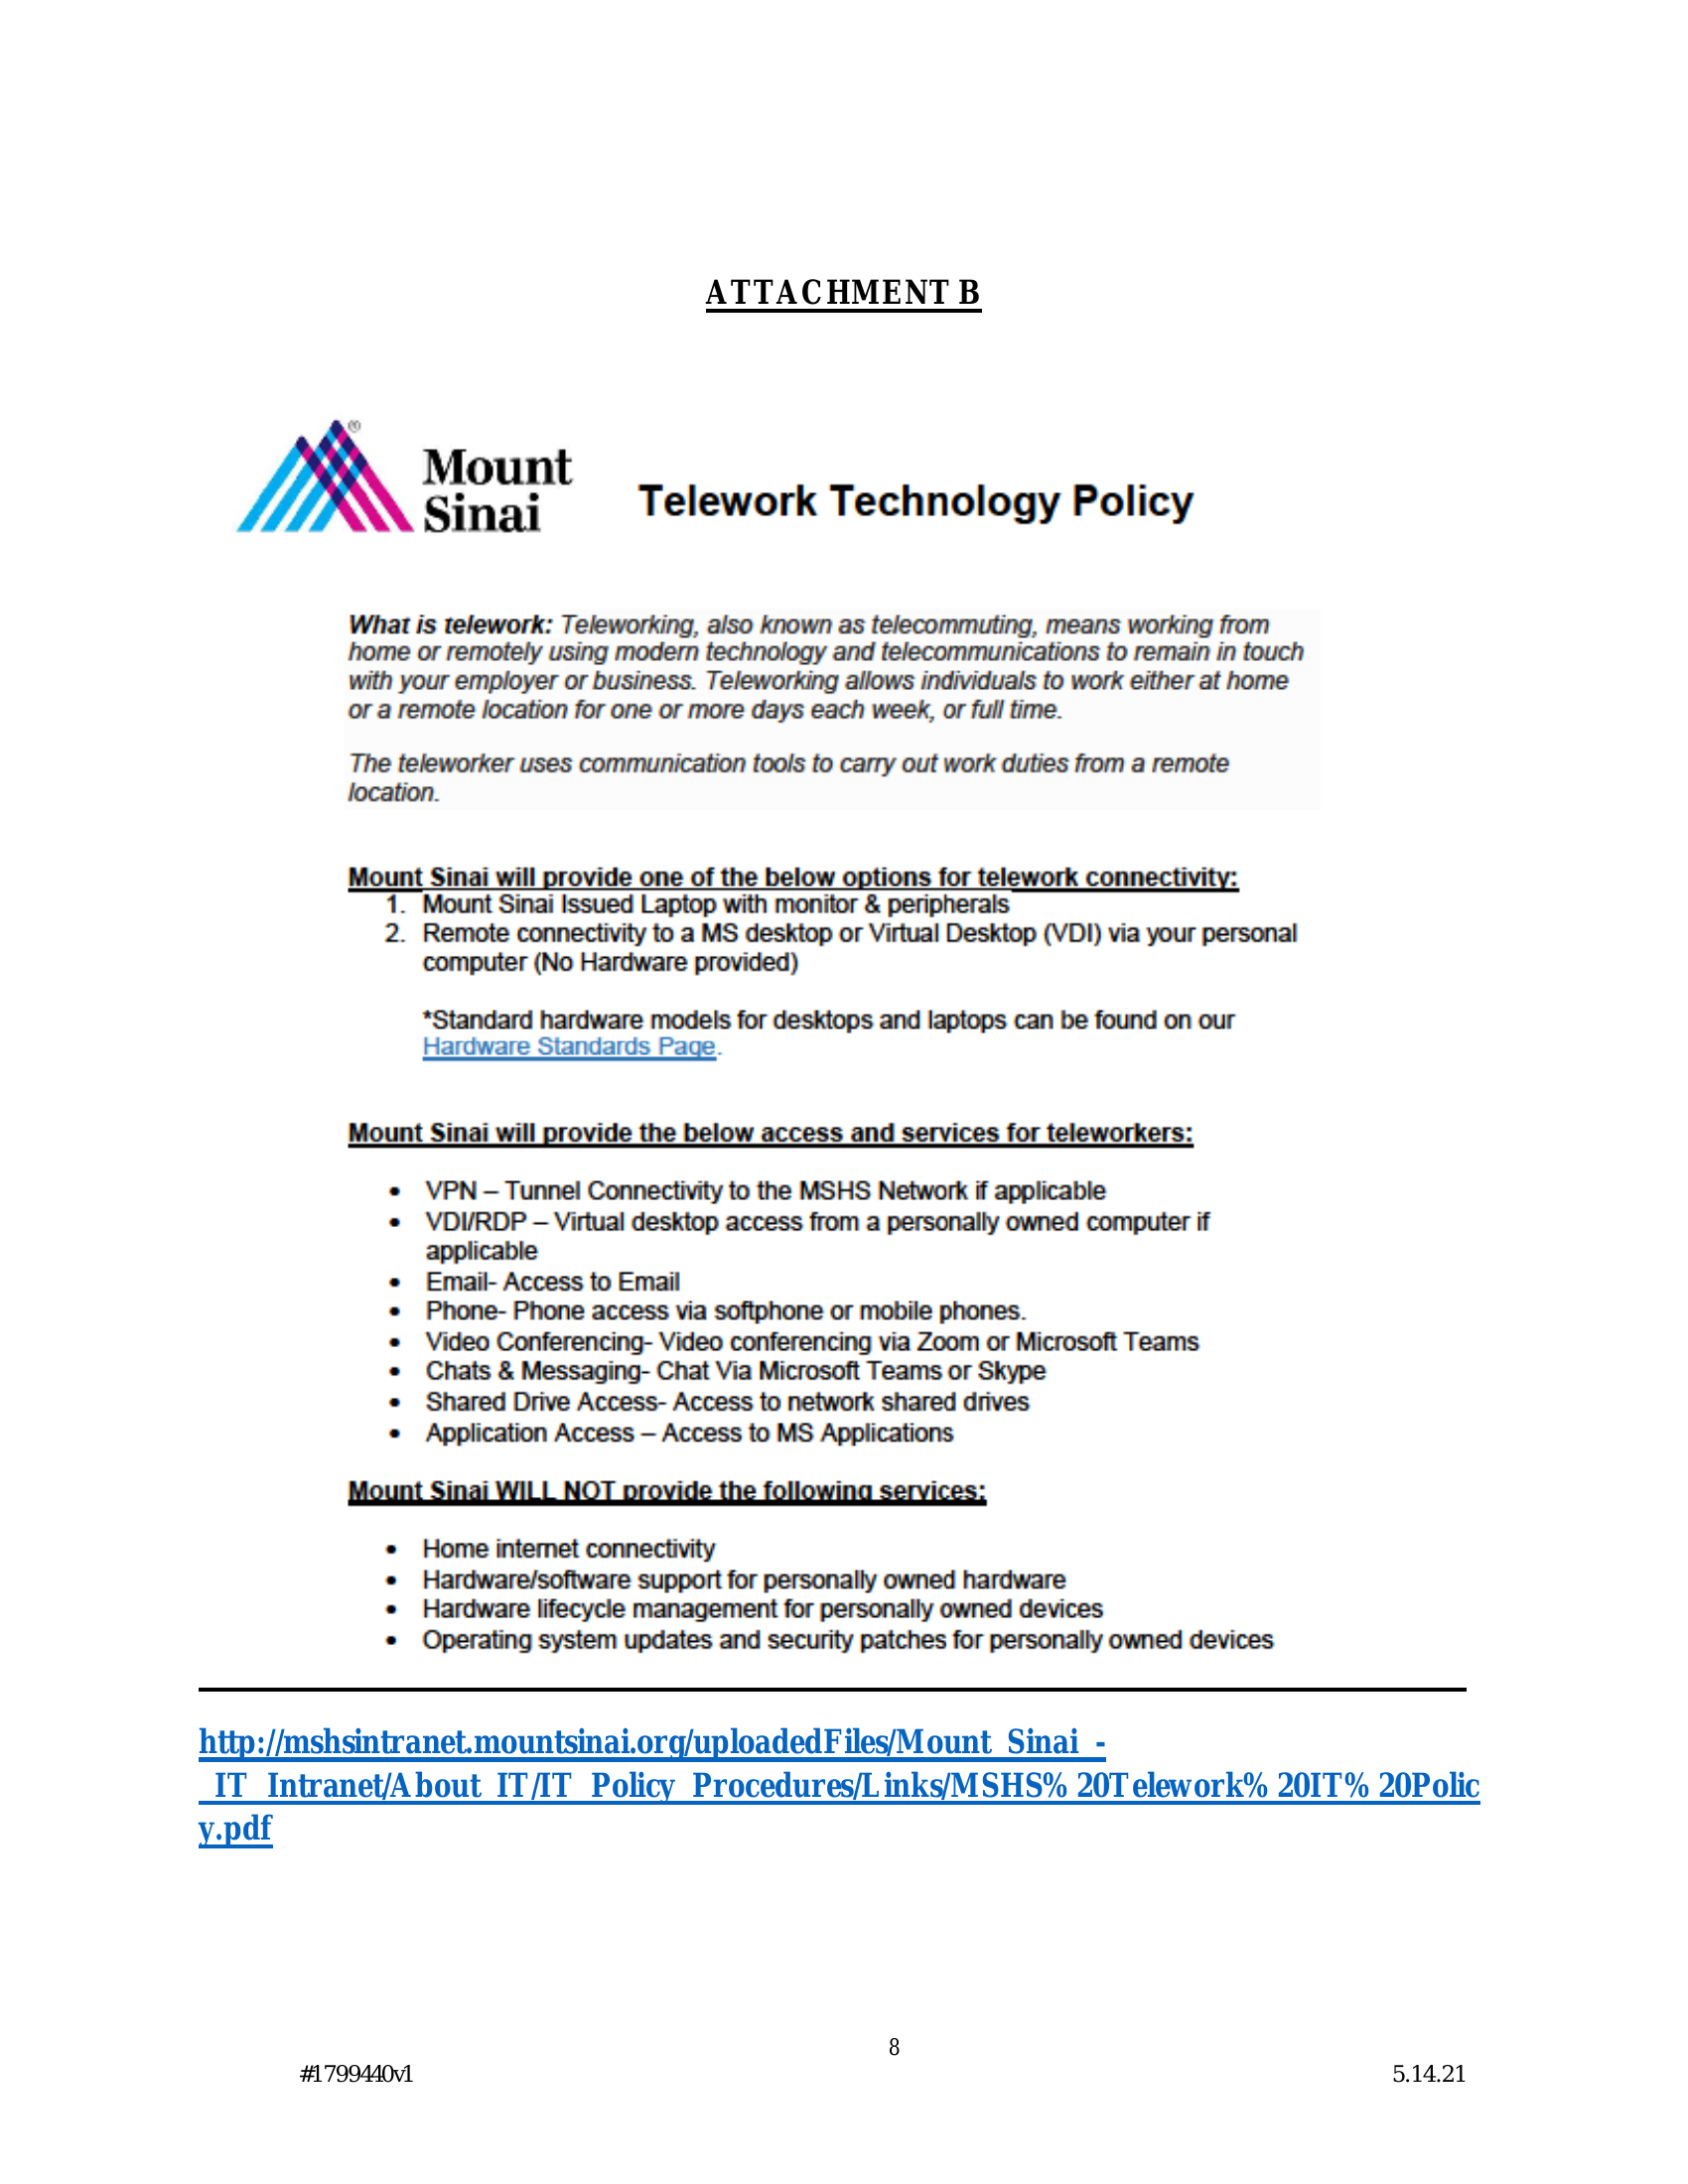

In [43]:
from IPython.display import display, HTML, Image


def display_image_from_document(document):
    pages = doc.pages
    for page in pages:
        base64_img = page.img_base64
        
        # Ensure the base64 string doesn't include the data URI scheme
        if base64_img.startswith('data:image'):
            base64_img = base64_img.split(',')[1]
        
        # Create an Image object
        image = Image(data=base64.b64decode(base64_img))
        
        # Display the image
        display(image)

document_name = "Work-From-Home-Guidance.pdf"

doc = client.get_document(document_name=document_name, collection_name="all", expand="pages")
print(doc.pages[0])

display_image_from_document(doc)

## Step 4: Extract data 

Now - that our document is ready. We can using LLMs with vision capabilities to extract data. 

We are using GPT-4o here, however depending on your use-case a lighter model might be more appropriate. Additionally, there are many optimization possible, including using Pydantic and Structured output from OpenAI to ensure valid JSON 100% of the time - these are beyond the scope of this example.

In [9]:
!pip install openai


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import json
from openai import OpenAI

llm_client = OpenAI(api_key="your-api-key")

data_to_extract = {"year_issued": 2014, "month_issued": 3}
# if your document is too big (20+ pages), or you want to extract data across multiple documents, consider a pipeline where you search first and get top 3 pages (see RAG cookbook), and then do this step.
# here since our document is small - we are passing the whole document at once.
def extract_data(data_to_extract, colivara_document):
    string_json = json.dumps(data_to_extract)
    content = [ 
                {
                "type": "text", 
                "text": f"""Use the following images as a reference to extract structured data with the following user example as a guide: {string_json}.\n
                If information is not available, keep the value blank.
                """,
                }
            ]
    pages = colivara_document.pages
    for page in pages:
        base64 = f"data:image/png;base64,{page.img_base64}"
        content.append(
            {
                    "type": "image_url",
                    "image_url": {"url": base64}
            }        
            )
    messages = [
                    {"role": "system", "content": "Our goal is to find out when a policy was issued to remind our users to review it at regular intervals. Always respond in JSON"},
                    {"role": "user", "content": content}
    ]
    completion = llm_client.chat.completions.create(
        model="gpt-4o",
        messages=messages,
        response_format= { "type": "json_object" },
        temperature=0.25,
        seed=123
        )
    return completion.choices[0].message.content


data = extract_data(data_to_extract, doc)
print(data)
# Convert JSON String to Python Dictionary
data_dict = json.loads(data)
print(f"Year Issued: {data_dict['year_issued']}")
print(f"Month Issued: {data_dict['month_issued']}")




{"year_issued": 2020, "month_issued": 3}
Year Issued: 2020
Month Issued: 3
